# Analyzing Investment Management Industry Firms 

If you're not familiar with the alternative assets space, it is generally known as being secretive and close lipped. 

Several of the largest names in the space have very few glassdoor reviews, ie: Tiger Global and Viking Global 

Company sizes are smaller 

Full list here https://www.peregrinecommunications.com/hubfs/Reports/Alts-50-Report-2021-Peregrine-Communications.pdf

In [54]:
import pandas as pd
import numpy as np
import requests
import time
import math
import re
import pickle
import itertools
import glob
import string

import contractions

from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk import FreqDist
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.collocations import *

from gsdmm import MovieGroupProcess

from textblob import TextBlob

import gensim 
import gensim.downloader as gensim_api
from gensim.models.phrases import Phrases
from gensim.models.phrases import Phraser
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC 
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler

# from tensorflow.keras import models, layers, preprocessing as kprocessing

from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from pyLDAvis import gensim_models
import pyLDAvis

import warnings
warnings.filterwarnings('ignore')

In [55]:
sns.set_style('darkgrid')
sns.set_palette("winter_r")

## Data
* Top Large Companies 
* Low Rated Large Companies 
* Lowly rated companies 

### Analysis
* What are the top companies doing really well? 
* From an employee standpoint, why are these the top companies? What matters to employees the most? 
* What are the companies performing poorly doing wrong? From an employee standpoint, why are these companies failing? 
* Are different types of employees feeling more or less valued? (analyze by position) 
* Topic Modeling 

### Prediction
* predict a review rating based on the incidence of certain words (ie: if you include great people, more likely to be a 5) 
    * feature engineering? bool for 'great people' or not? 

* Feature engineering: Sentiment analysis on headline - ie: pos, neut, neg headline - is this a predictor for rating as well? 

* Can we predict the rating based on text? Can be used for surveys and other text based feedback. 
* Has the sentiment at top companies stayed the same over time? 
* Classification

* Rating a company as 'desirable' or 'not desirable'
* Desirable company: 4-5 stars avg since 2019
* Not desirable: < 4 stars avg since 2019 

## Load Files 

In [56]:
"""
Takes in a list of csv files using glob 
Output: dataframe combining all csvs vertically (axis=0)
Assumes all csvs have same column names 
"""
def files_to_df(glob_csv):
    final_df = pd.DataFrame()
    
    for file in glob_csv:
        company_name = file.split('\\')[1].split('.')[0] # get the company name from the file 
        try:
            df = pd.read_csv(file)
        except:
            df = pd.read_csv(file, encoding='latin1')
        
        # drop the extra index column 
        df = df.drop(df.columns[0], axis=1)
        
        #check if there's a company column, if not, add company name to all rows  
        if pd.isnull(df.iloc[0].company):
            df.company = company_name
        
        final_df = pd.concat([final_df, df])
        
    return final_df

In [57]:
""" 
Load all csv files from folders 
drop each group into a dataframe 

"""
csvfiles = glob.glob('reviews/investment/' + '*.csv')
investment_reviews_raw =  files_to_df(csvfiles)

In [58]:
print(investment_reviews_raw.isna().sum())
print(len(investment_reviews_raw))

company               0
headline             24
date                  0
overall_rating        0
author_position    1040
pros                  0
cons                  0
dtype: int64
9660


In [59]:
investment_reviews_raw.company.unique()

array(['Advent', 'Allianz Global Investors', 'Angelo Gordon',
       'Apollo Global Management', 'AQR Capital Management',
       'Ares Management', 'Bain Capital', 'Balyasny Asset Management',
       'Bayview Asset Management', 'Bessemer Trust Company',
       'Boston Private', 'Bridgewater', 'Brookfield Asset Management',
       'Cerberus', 'Citadel', 'CPP Investments', 'CVC', 'DE Shaw',
       'Evercore Partners', 'Fortress Investment Group',
       'Geller & Company', 'Guggenheim', 'HarbourVest Partners, LLC',
       'Intellectual Ventures', 'Jane Street', 'Janus Capital',
       'Jump Trading', 'KKR', 'Lazard', 'Legg Mason', 'Lord Abbett & Co.',
       'Man Group', 'Millennium', 'Moelis & Company', 'Moelis',
       'Neuberger Berman', 'Oaktree Capital Management',
       'Oppenheimer Holdings', 'Partners Capital', 'PIMCO',
       'PineBridge Investments', 'Point72', 'Putnam Investments',
       'Sculptor Capital', 'Silver Lake', 'SoftBank', 'Techstars',
       'The Blackstone Grou

# EDA 

* Who are the top firms? 
* Are there similarities between these companies and the GD top companies? 
* For the companies that are not doing well, what are the reasons? 
* Are different types of employees feeling more or less valued? (analyze by position) 
* Which companies are on an upward trend? 
* Can we predict the rating based on the review? 

## Prep Data

### Define Methods

In [94]:
def position_level(position):
    executive_pattern = re.compile("[Cc]\w[Oo]")
    sr_manager_pattern = re.compile("(senior)\s(\w*)\s(manager)")
    if executive_pattern.match(position.lower()) or sr_manager_pattern.match(position.lower()):
        return "senior"
    
    senior = ["director", "chief", "executive", "senior manager", "head", "general manager", "leader", "president", "vp"]
    for pos in senior:
        if pos in position.lower():
            return "senior"
    
    return "other"


def position_department(position):
    try: 
        marketing_sales = ["marketing", "sales", "account manager","business development", "investor relations", "IR", "client",'customer']
        for pos in marketing_sales:
            if pos in position.lower():
                return "marketing_sales"

        hr = ["human", "hr", "recruit", "talent", "l&d", "learning", "people", "culture", "diversity", "inclusion"]
        for pos in hr:
            if pos in position.lower():
                return "hr_admin_legal"

        finance = ["accounting", 'operations', "valuation", "controller", "accountant", "finance", "payable", "receivable", "financial", "financial analyst", "fp"]
        for pos in finance:
            if pos in position.lower():
                return "accounting_finance_ops"

        tech = ["engineer", "data", "software", "ux", "ui", "experience", "developer", "product", "tech", "programmer", "it ", "information", "solution"]
        for pos in tech:
            if pos in position.lower():
                return "technology"
        
        investment = ["investment", "risk", "quantitative", "quant", "analyst", "trading", "trader", "investor", "front office", "portfolio"]
        for pos in investment:
            if pos in position.lower():
                return "investment"
        
        admin = ['assistant', 'administrative','receptionist', 'front desk','facilities']
        for pos in admin:
            if pos in position.lower():
                return "hr_admin_legal"
            
        legal = ['legal', 'attorney','legal', 'compliance']
        for pos in legal:
            if pos in position.lower():
                return "hr_admin_legal"
            
        intern = ['intern','student','summer']
        for pos in intern:
            if pos in position.lower():
                return "intern"
            
    except:
        print(position)
    
    return "other"

def fill_missing_values(df):
    position_missing = df.author_position.isna().sum()
    headline_missing = df.headline.isna().sum()
    print(df.isna().sum())
#     print(f"There are {position_missing} missing position records.")
#     print(f"There are {headline_missing} missing headline records.")
    
    df.author_position = df.author_position.fillna("unknown")
    df.headline = df.headline.fillna('')
    df.pros = df.pros.fillna('')
#     print('After filling missing values: ')
#     print(df.isna().sum())

    return df 

# 
def create_position_cols(df):
    df['position_department'] = df.author_position.apply(lambda x: position_department(x))
    df['position_level'] = df.author_position.apply(lambda x: position_level(x))
    return df 

# convert date column to datetime 
def convert_datetime(df):
    df.date = pd.to_datetime(df.date, format='%Y-%m-%d')
    return df

# Add mean rating column 
def add_mean_rating(df):
    reviews_by_rating = df.groupby('company').overall_rating.mean().reset_index().rename(columns={'overall_rating':'mean_rating'})
    rating_dict = reviews_by_rating.set_index('company').to_dict()['mean_rating']
    df['mean_rating'] = df.company.apply(lambda x: float(rating_dict[x]))
    return df

# add review count column 
def add_review_count(df):
    reviews_count = df.groupby('company').headline.count().reset_index().rename(columns={'headline':'count'})
    count_dict = reviews_count.set_index('company').to_dict()['count']
    df['review_count'] = df.company.apply(lambda x: int(count_dict[x]))
    return df

# requires review_count column 
def remove_reviews(df, count=50):
    if 'review_count' not in df.columns:
        print('No review count column.')
        return df
    else:
        company_count = df.groupby('company').review_count.mean().reset_index()
        print(f'\nRemoving following companies with less than {count} reviews:')
        print(list(company_count[company_count.review_count < count].company))
        return df[df.review_count >= count]
    

In [95]:
# Cleaning and new columns 
reviews = convert_datetime(investment_reviews_raw)
reviews = reviews[reviews.date > '2011-12-31']  # only reviews in the past 10 years 
reviews = fill_missing_values(reviews)
reviews = create_position_cols(reviews) # create column for author position 

# print(f'There are {len(reviews[reviews.pros.apply(lambda x: pd.isnull(x))])} reviews with no text in the pros column.')
reviews = add_mean_rating(reviews)
reviews = add_review_count(reviews) 

company              0
headline            24
date                 0
overall_rating       0
author_position    976
pros                 0
cons                 0
dtype: int64

Removing following companies with less than 50 reviews:
['Advent', 'Angelo Gordon', 'CVC', 'Cerberus', 'Silver Lake']


In [96]:
print(len(reviews))

9381


## Overall review time trends

In [97]:
"""
visualize distribution of reviews by year.
input requires a 'date' and a headline column in datetime format
plots barplot 
"""

def reviews_by_year(df, display=True):
    temp_df = df.copy()
    temp_df['year'] = temp_df.date.apply(lambda x: x.year)
    count_year = temp_df.groupby('year').headline.count().reset_index()
    count_year['count_normalized'] = round(((count_year['headline'] / count_year['headline'].sum()) * 100),2)
    plt.figure(figsize=(12,6))
    sns.barplot(x = count_year.year, y=count_year.headline, palette='winter')
    plt.show()
    if display:
        print(count_year[['year','count_normalized']])

def reviews_by_month(df, display=True):
    temp_df = df.copy()
    temp_df['month'] = temp_df.date.apply(lambda x: x.month)
    count_month = temp_df.groupby('month').headline.count().reset_index()
    count_month['count_normalized'] = round(((count_month['headline'] / count_month['headline'].sum()) * 100),2)
    plt.figure(figsize=(12,6))
    sns.barplot(x = count_month.month, y=count_month.headline, palette='winter')
    plt.show()
    if display:
        print(count_month[['month','count_normalized']])

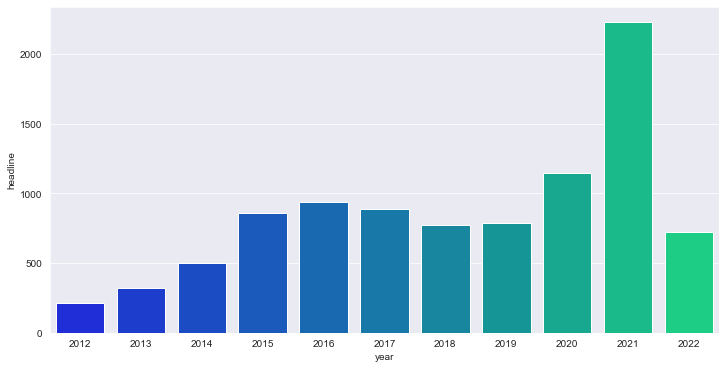

    year  count_normalized
0   2012              2.27
1   2013              3.44
2   2014              5.37
3   2015              9.14
4   2016             10.00
5   2017              9.44
6   2018              8.27
7   2019              8.37
8   2020             12.24
9   2021             23.76
10  2022              7.70


In [82]:
reviews_by_year(reviews)

In [84]:
# TODO overlay on hiring trends
# ie: are there more reviews when there is more turnover in the labor market 

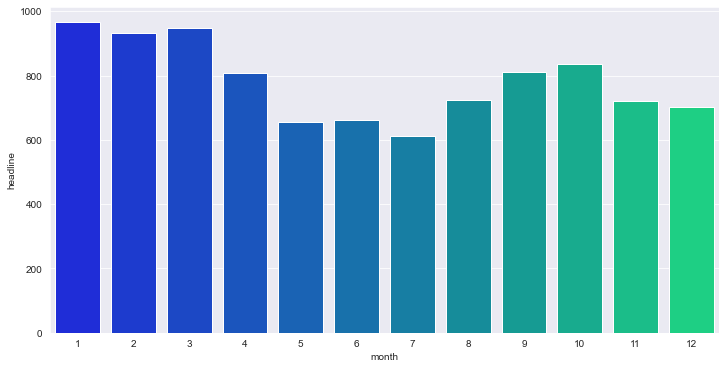

    month  count_normalized
0       1             10.30
1       2              9.95
2       3             10.12
3       4              8.61
4       5              6.97
5       6              7.06
6       7              6.53
7       8              7.72
8       9              8.66
9      10              8.92
10     11              7.70
11     12              7.47


In [83]:
reviews_by_month(reviews)

## Who are the top firms?

In [102]:
# TODO create a method for rankings called get_rankings, so that code isn't repeated

In [99]:
# what are the average ratings per company? 
review_rankings = reviews.groupby('company').mean_rating.mean().reset_index().sort_values(by='mean_rating', ascending=False)

# how many reviews per company? 
review_counts = reviews.groupby('company').review_count.mean().reset_index().sort_values(by='review_count',ascending=True)
review_counts.review_count = review_counts.review_count.apply(lambda x: int(x))

# merge together
company_rankings = review_rankings.merge(review_counts, left_on='company', right_on='company')

# remove companies with less than 100 reviews
company_rankings = remove_reviews(company_rankings,count=100)
company_rankings


Removing following companies with less than 100 reviews:
['Balyasny Asset Management', 'HarbourVest Partners, LLC', 'Sculptor Capital', 'Warburg Pincus']


,company,mean_rating,review_count
0,Two Sigma,4.300000,110
2,Jane Street,4.256250,160
3,Jump Trading,4.254545,110
4,DE Shaw,4.250000,128
5,Techstars,4.120000,100
6,Bain Capital,4.120000,150
7,Evercore Partners,4.104167,240
9,KKR,4.036842,190
11,The Blackstone Group,3.990123,405
12,Point72,3.873469,245


### Are there any differences in rankings since pandemic? 

In [101]:
# create df for recent reviews 
recent_reviews = reviews[reviews.date > '2020-03-01'] 

# what are the average ratings per company? 
review_rankings = recent_reviews.groupby('company').mean_rating.mean().reset_index().sort_values(by='mean_rating', ascending=False)

# how many reviews per company? 
review_counts = recent_reviews.groupby('company').review_count.mean().reset_index().sort_values(by='review_count',ascending=True)
review_counts.review_count = review_counts.review_count.apply(lambda x: int(x))

# merge together
company_rankings_pandemic = review_rankings.merge(review_counts, left_on='company', right_on='company')

# remove companies with less than 100 reviews
company_rankings_pandemic = remove_reviews(company_rankings_pandemic,count=100)
company_rankings_pandemic 


Removing following companies with less than 100 reviews:
['Balyasny Asset Management', 'HarbourVest Partners, LLC', 'Sculptor Capital', 'Warburg Pincus']


,company,mean_rating,review_count
0,Two Sigma,4.300000,110
2,Jane Street,4.256250,160
3,Jump Trading,4.254545,110
4,DE Shaw,4.250000,128
5,Techstars,4.120000,100
6,Bain Capital,4.120000,150
7,Evercore Partners,4.104167,240
9,KKR,4.036842,190
11,The Blackstone Group,3.990123,405
12,Point72,3.873469,245


Interpretation: There doesn't appear to be any differences since the pandemic with overall rankings 

## How have companies been rated over time? 
* For the past 10 years, what do the trends look like? 
* How have companies done in the pandemic? 

In [109]:
reviews.company.unique()

array(['Allianz Global Investors', 'Apollo Global Management',
       'AQR Capital Management', 'Ares Management', 'Bain Capital',
       'Balyasny Asset Management', 'Bayview Asset Management',
       'Bessemer Trust Company', 'Boston Private', 'Bridgewater',
       'Brookfield Asset Management', 'Citadel', 'CPP Investments',
       'DE Shaw', 'Evercore Partners', 'Fortress Investment Group',
       'Geller & Company', 'Guggenheim', 'HarbourVest Partners, LLC',
       'Intellectual Ventures', 'Jane Street', 'Janus Capital',
       'Jump Trading', 'KKR', 'Lazard', 'Legg Mason', 'Lord Abbett & Co.',
       'Man Group', 'Millennium', 'Moelis & Company', 'Moelis',
       'Neuberger Berman', 'Oaktree Capital Management',
       'Oppenheimer Holdings', 'Partners Capital', 'PIMCO',
       'PineBridge Investments', 'Point72', 'Putnam Investments',
       'Sculptor Capital', 'SoftBank', 'Techstars',
       'The Blackstone Group', 'The Carlyle Group', 'TPG', 'Two Sigma',
       'Warburg Pincus'

In [132]:
""" 
For seeing trends for multiple companies 
Plot average yearly rating of a list of companies on one plot 
input: df of companies with ratings, number of colums for plot (optional), figure size for plot (optional)
output: group of subplots with line charts visualizing yearly overall rating of companies 
"""
def plot_company_rankings_yearly(df, num_cols=4, figsize=(25,15)):
    # get the list of companies and number of plots 
    company_lst = df.company.unique()
    total_subplots = len(company_lst) 
    cols = num_cols 
    rows = total_subplots // cols
    if total_subplots % cols > 0:
        rows+=1
    print(f"Total plots: {total_subplots}, Total cols: {cols}, Total rows: {rows}")
    
    # set index to 0, index is used for iterating through the company list 
    index=0
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=figsize) 
    for row in range(axes.shape[0]):
        for col in range(axes.shape[1]):
            # delete plots that are not going to be used 
            if index >= total_subplots:
                fig.delaxes(axes[row,col])
                index+=1
            else: 
                ax = axes[row,col] 
                # get company df for plotting 
                company_name = company_lst[index] 
                company_df = df[df.company==company_name]
                company_df['year'] = company_df.date.apply(lambda x: x.year)
                rating_per_year = company_df.groupby('year').overall_rating.mean().reset_index()
                # plot the company on the right ax 
                rating_per_year.plot(x='year',y='overall_rating',ax=ax)
                ax.set_title(f'{company_name} ratings')
                ax.set_xticks(rating_per_year.year)
                ax.set_xticklabels(rating_per_year.year)
    #             ax.axis('off')
                index += 1

    plt.tight_layout()


""" 
For zooming in on one company 
Plot average yearly rating of a single company
output: line chart 
"""
def plot_ranking_yearly(df, company):
    company_df = df[df.company==company]
    company_df['year'] = company_df.date.apply(lambda x: x.year)
    rating_per_year = company_df.groupby('year').overall_rating.mean().reset_index()
    
    fig, ax = plt.subplots(figsize=(12,6))
    rating_per_year.plot(x='year',y='overall_rating',ax=ax)
    ax.set_title(f'{company} ratings')
    ax.set_xticks(rating_per_year.year)
    ax.set_xticklabels(rating_per_year.year)
    
    plt.show()

Total plots: 47, Total cols: 4, Total rows: 12


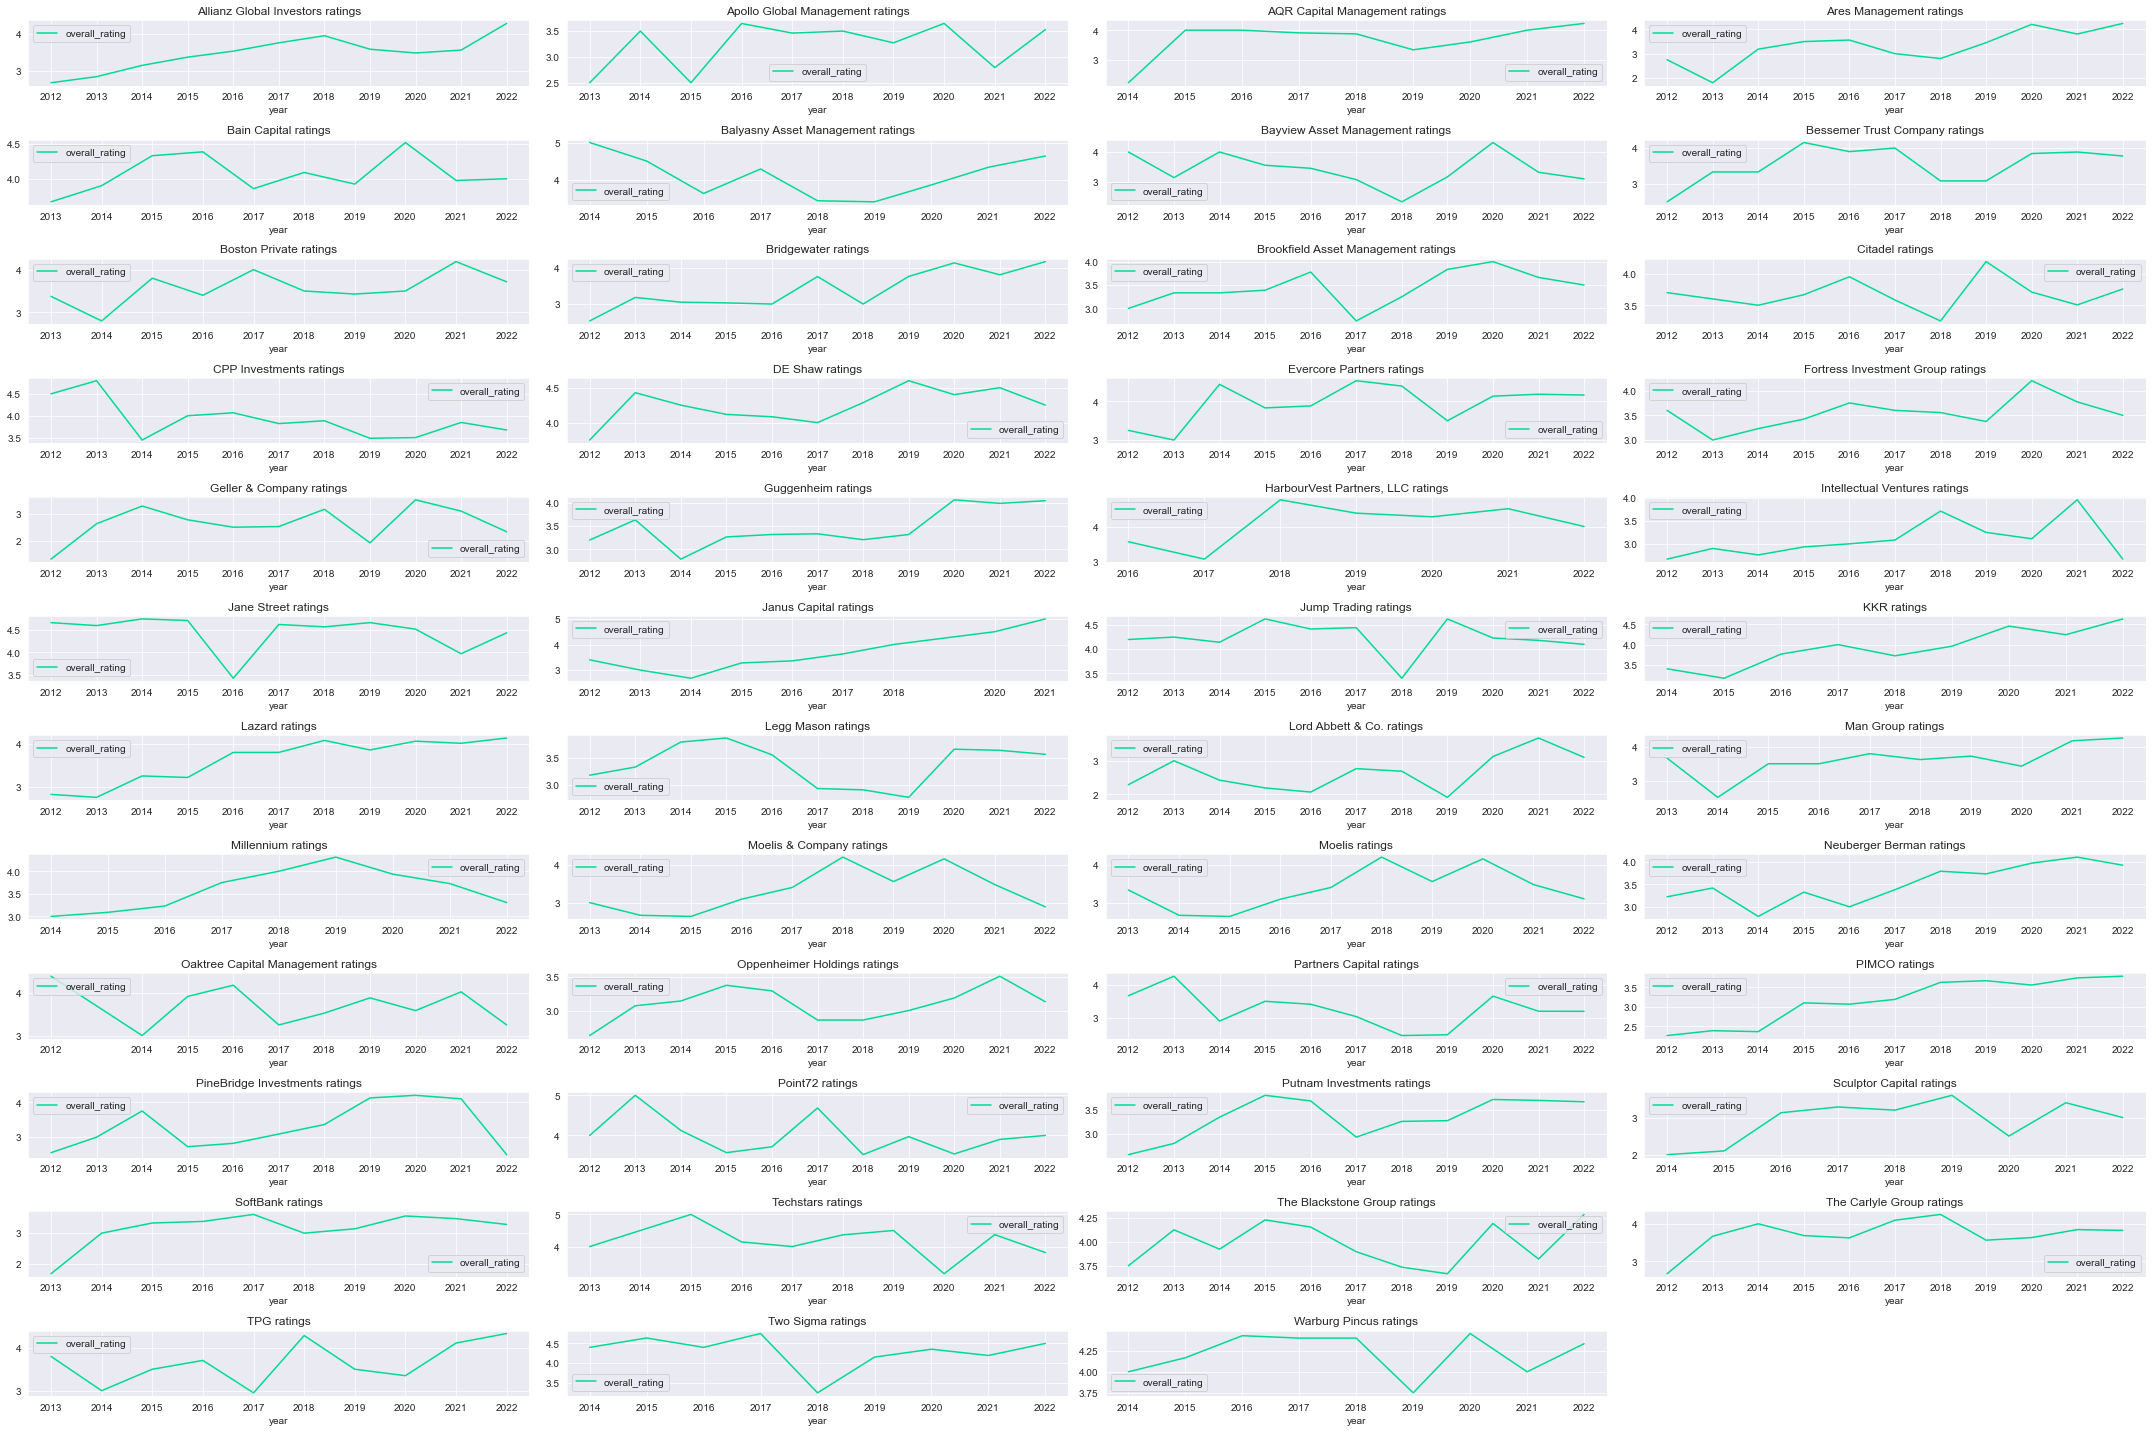

In [136]:
plot_company_rankings_yearly(reviews, figsize=(30,20))

These companies look like they are trending in a negative direction, especially since the pandemic:
* Intellectual Ventures 
* Lord Abbett 
* Fortress
* Brookfield 
* Moelis 

These companies look like they are trending in a positive direction, especially since the pandemic:
* Jane Street
* Ares Management  
* KKR 
* Warburg Pincus 
* Citadel 

Further investigation to follow in coming steps. 

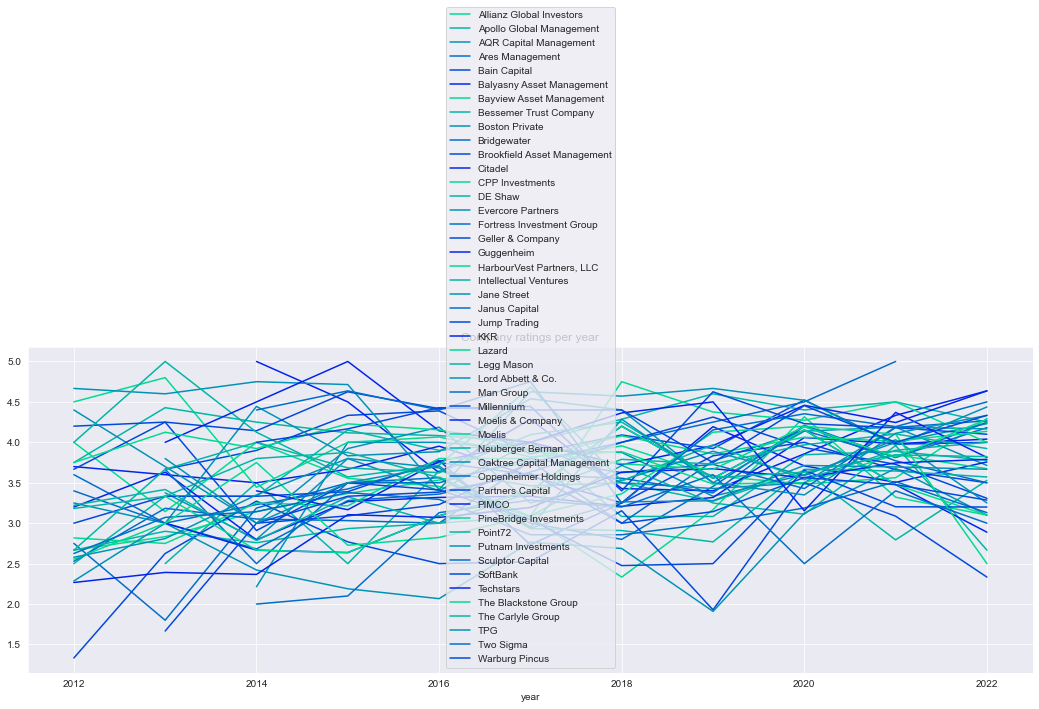

In [139]:
# TODO deprecate or limit to a small number of companies 
# get the list of companies and number of plots 
company_lst = reviews.company.unique()

fig, ax = plt.subplots(figsize=(18,6)) 
for company in company_lst:
    # get company reviews for plotting 
    company_data = reviews[reviews.company==company]
    company_data['year'] = company_data.date.apply(lambda x: x.year)
    rating_per_year = company_data.groupby('year').overall_rating.mean().reset_index()
    # plot the company on the right ax 
    rating_per_year.plot(x='year',y='overall_rating',ax=ax, label=f'{company}')
    plt.title('Company ratings per year')
#     ax.set_xticks(rating_per_year.year)
#     ax.set_xticklabels(rating_per_year.year)
plt.legend()
plt.show()

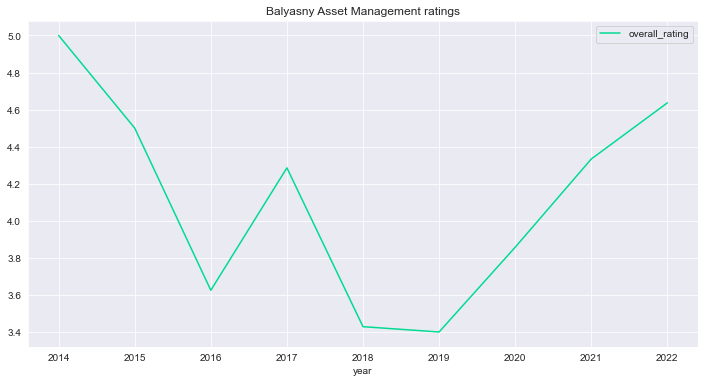

In [135]:
plot_ranking_yearly(reviews, 'Balyasny Asset Management')

### How have these companies done during the pandemic? 

* Intellectual Ventures 
* Lord Abbett 
* Fortress
* Brookfield 
* Moelis 

These companies look like they are trending in a positive direction, especially since the pandemic:
* Jane Street
* Ares Management  
* KKR 
* Warburg Pincus 
* Citadel 

In [ ]:
""" 
For seeing trends for multiple companies and zooming in during the pandemic 
Plot average monthly rating of a list of companies on one plot 
input: df of companies with ratings, number of colums for plot (optional), figure size for plot (optional)
output: group of subplots with line charts visualizing yearly overall rating of companies 
"""
def plot_company_rankings_pandemic(df, num_cols=4, figsize=(25,15)):
    # get the list of companies and number of plots 
    company_lst = df.company.unique()
    total_subplots = len(company_lst) 
    cols = num_cols 
    rows = total_subplots // cols
    if total_subplots % cols > 0:
        rows+=1
    print(f"Total plots: {total_subplots}, Total cols: {cols}, Total rows: {rows}")
    
    # set index to 0, index is used for iterating through the company list 
    index=0
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=figsize) 
    for row in range(axes.shape[0]):
        for col in range(axes.shape[1]):
            # delete plots that are not going to be used 
            if index >= total_subplots:
                fig.delaxes(axes[row,col])
                index+=1
            else: 
                ax = axes[row,col] 
                # get company df for plotting 
                company_name = company_lst[index] 
                company_df = df[df.company==company_name]
                company_df['mon_year'] = company_df.date.dt.to_period('M')
                rating_per_year = company_df.groupby('mon_year').overall_rating.mean().reset_index()
                # plot the company on the right ax 
                rating_per_year['2020':].plot(x='year',y='overall_rating',ax=ax)
                ax.set_title(f'{company_name} ratings')
#                 ax.set_xticks(rating_per_year['2020':].index)
#                 ax.set_xticklabels(rating_per_year['2020':].index, rotation=30)
    #             ax.axis('off')
                index += 1

    plt.tight_layout()

def plot_ranking_pandemic(df, company):
    company_df = df[df.company==company]
    company_df['mon_year'] = company_df.date.dt.to_period('M')
    rating_per_year = company_df.groupby('mon_year').overall_rating.mean().reset_index()
    
    fig, ax = plt.subplots(figsize=(12,6))
    rating_per_year['2020':].plot(x='year',y='overall_rating',ax=ax)
    ax.set_title(f'{company} ratings')
#     ax.set_xticks(rating_per_year['2020':].index)
#     ax.set_xticklabels(rating_per_year['2020':].index, rotation=30)
    plt.show()

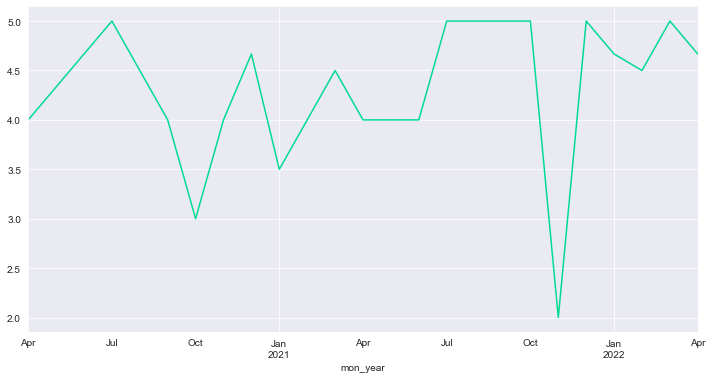

In [52]:
bx = reviews[reviews.company=='Balyasny Asset Management']
bx['mon_year'] = bx.date.dt.to_period('M')
rating_per_year = bx.groupby('mon_year').overall_rating.mean()
fig, ax = plt.subplots(figsize=(12,6))
rating_per_year['2020':].plot(ax=ax)
# ax.set_xticks(rating_per_year['2020':].index)
# ax.set_xticklabels(rating_per_year['2020':].index, rotation=30)
plt.show()
# rating_per_year.plot(x='year',y='overall_rating')


##  Are different types of employees feeling more or less valued? (analyze by position) 


In [103]:
"""testing"""
# reviews[reviews.author_position.apply(lambda x: 'legal' in x.lower())]
# reviews[(reviews.position_department == 'other') & (reviews.author_position.apply(lambda x: 'anonymous' not in x.lower()))][-50:]

'testing'

In [104]:
rating_by_dept = reviews.groupby('position_department').overall_rating.mean().reset_index().sort_values(by='overall_rating', ascending=False)
count_by_dept = reviews.groupby('position_department').pros.count().reset_index().rename(columns={'pros':'count'})
rating_by_dept.merge(count_by_dept, left_on='position_department', right_on='position_department')

,position_department,overall_rating,count
0,intern,4.210526,133
1,investment,3.780343,1516
2,technology,3.706858,904
3,hr_admin_legal,3.612100,562
4,accounting_finance_ops,3.567010,485
5,other,3.539154,5440
6,marketing_sales,3.486804,341


In [106]:
# TODO add count to this as well, so you can see how many reviews per level 
reviews.groupby('position_level').overall_rating.mean().reset_index().sort_values(by='overall_rating', ascending=False)

,position_level,overall_rating
1,senior,3.670744
0,other,3.600357


# Text Preprocessing

* Using Regex & NLTK libraries
* Noise Removal – Removing unnecessary characters and formatting
* Tokenization – break multi-word strings into smaller components
* Normalization – a catch-all term for processing data; this includes stemming and lemmatization
    * Upper or lowercasing
    * Stopword removal
    * Stemming – bluntly removing prefixes and suffixes from a word
    * Lemmatization – replacing a single-word token with its root

## Define Methods

In [10]:
# TODO find a better way to remove companies ie: BX, blackstone, blackstone group

# https://www.analyticsvidhya.com/blog/2018/10/mining-online-reviews-topic-modeling-lda/

def preprocess_text(text, company_list):
    
    # remove html, hyphens, numbers 
    r_unwanted = re.compile("(\\.)|(\s-)|(^-)|(\d)|([+])|(\s[\'\"])|([\'\"]\s)")

    # make all words lowercase, and sub in regex  
    text = r_unwanted.sub(' ',text.lower())
#     print("First pass: ", text,"\n")
    
    # remove mentions of company 
    for company in company_list:
        text = text.replace(company, "")
    
#     # remove spelling mistakes 
#     text = str(TextBlob(text).correct())
#     print("Spelling Corrected: ", text,"\n")
    
    # contractions 
    text = text.replace("’","'")
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    tokens_raw = nltk.regexp_tokenize(text, pattern)
#     print('Tokens Raw: ', tokens_raw)
    expanded_tokens = [w for word in tokens_raw for w in contractions.fix(word).split()]
#     print('Expanded Tokens: ', expanded_tokens)

    # create a stopwords list including numbers and punctuation
    stopwords_list = stopwords.words('english')
    stopwords_list += list(string.punctuation)
    stopwords_list += ['there\'s',"'s", 'n\'t', '\'ve','\'m','’',"lot"]
    
    # tokenize words 
    text_lst = [word for word in expanded_tokens if word not in stopwords_list and len(word) > 1]
    
#     print("Stopwords removed: ", text_lst,"\n")
        
    # lemmatize words 
    lemmatizer = WordNetLemmatizer()
    lemmatized_lst = [lemmatizer.lemmatize(word) for word in text_lst]
#     print("lemmatized: ", text_lst,"\n")

           
    # combine into one string from list                                      
    final_lst = " ".join(lemmatized_lst)
    return final_lst



def get_company_list(df):
    final_lst = []
    for company in df.company.unique():
        final_lst.append(company.lower())
    return final_lst



In [16]:
# company_list = get_company_list(top_recent_reviews)
# test_review = "I'm proud to work at Atlassian because"
# preprocess_text(test_review, company_list)

""" TESTING """
test = df[df.headline == 'Run for the hills'].pros.values[0]
test = df[df.pros.apply(lambda x: 'e.g' in x)].pros.iloc[0]
preprocess_text(test, company_list)

'executive leader great job driving company government investment ipo learned variety role decent comp benefit even improved benefit time parental leave expansion benefit lgbt partner'

In [13]:
with open('investment_company_reviews_df.pickle', 'rb') as f:
    df = pickle.load(f)

In [ ]:
# TODO keep reviews with only less than 100 words? 
# # remove reviews with too many words in pros column  
# print(f'There are {len(reviews[reviews.pros.apply(lambda x: len(x.split()) > 100)])} reviews with more than 100 words.')
# reviews = reviews[reviews.pros.apply(lambda x: len(x.split()) < 100)]

In [12]:
company_list = get_company_list(reviews)
df = reviews
df['pros_cleaned'] = df['pros'].apply(lambda x: preprocess_text(x, company_list))
df['cons_cleaned'] = df['cons'].apply(lambda x: preprocess_text(x, company_list))
df['headline_cleaned'] = df['headline'].apply(lambda x: preprocess_text(x, company_list))
df['combined_text'] = df['pros_cleaned'] + " " + df['cons_cleaned'] + " " + df['headline_cleaned']
df.head()

with open('investment_company_reviews_df.pickle', 'wb') as f:
    pickle.dump(df, f)

KeyboardInterrupt: 

In [14]:
df.head()

,company,headline,date,overall_rating,author_position,pros,cons,position_department,position_level,pros_cleaned,cons_cleaned,headline_cleaned,combined_text
0,Allianz Global Investors,Great People,2022-04-21,5.0,Human Resources Business Partner,"People, benefits, management, team and culture.",I have no cons to share,hr,other,people benefit management team culture,con share,great people,people benefit management team culture con sha...
1,Allianz Global Investors,Great company,2022-04-11,5.0,Working Student,"Good culture, interesting company, great colle...",not encountered any so far,other,other,good culture interesting company great colleague,encountered far,great company,good culture interesting company great colleag...
2,Allianz Global Investors,Working Student,2022-04-07,5.0,Working Student,"Good company, nice colleagues, good perks","Nothing at the moment, everything is fine",other,other,good company nice colleague good perk,nothing moment everything fine,working student,good company nice colleague good perk nothing ...
3,Allianz Global Investors,Good employer,2022-04-05,5.0,IT Project Manager,Flexible working \r\nNice colleagues\r\nNew te...,the management is not always aligned to the cu...,technology,other,flexible working nice colleague new technology...,management always aligned current technology,good employer,flexible working nice colleague new technology...
4,Allianz Global Investors,Mostly positive experience,2022-03-31,4.0,Analyst,Staff are generally approachable and collabora...,Internal decision making can be overly politic...,investment,other,staff generally approachable collaborative nic...,internal decision making overly political thus...,mostly positive experience,staff generally approachable collaborative nic...


## General Data Exploration

In [405]:
df.groupby('position_level').overall_rating.mean().reset_index()

,position_level,overall_rating
0,other,3.575436
1,senior,3.616290


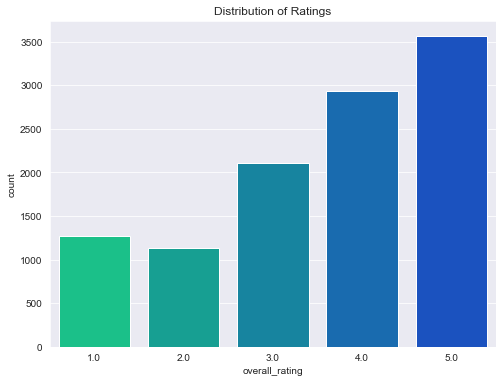

In [406]:
plt.figure(figsize=(8,6))
plt.title('Distribution of Ratings')
sns.countplot(df['overall_rating'])
plt.show()

In [16]:
print(f'Model that only guesses 5 will have a {round(len(df[df.overall_rating==5.]) / len(df)*100,2)}% accuracy rate.')

Model that only guesses 5 will have a 32.36% accuracy rate.


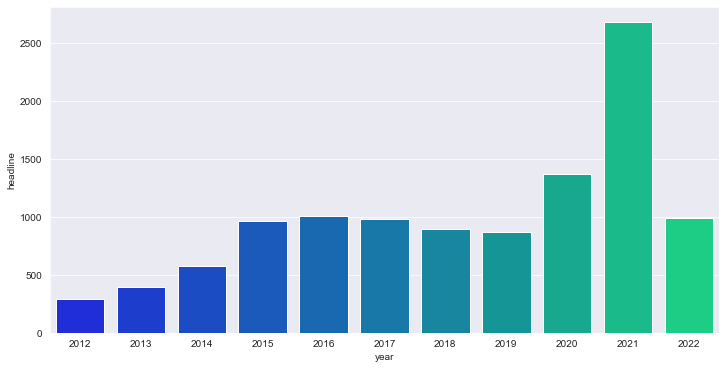

    year  count_normalized
0   2012              2.68
1   2013              3.56
2   2014              5.27
3   2015              8.75
4   2016              9.14
5   2017              8.90
6   2018              8.09
7   2019              7.93
8   2020             12.42
9   2021             24.31
10  2022              8.95


In [17]:
reviews_by_year(df)

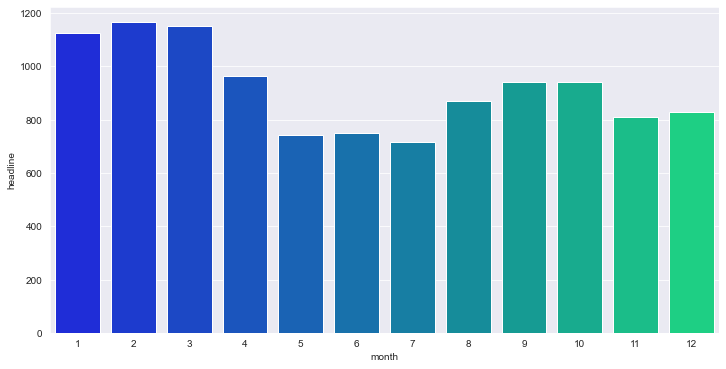

    month  count_normalized
0       1             10.23
1       2             10.59
2       3             10.47
3       4              8.76
4       5              6.76
5       6              6.82
6       7              6.52
7       8              7.89
8       9              8.55
9      10              8.53
10     11              7.35
11     12              7.53


In [18]:
reviews_by_month(df)

* Reviews spiked in 2021
* ~2X as many reviews in 2021 than in 2020 
* More reviews in Q1 than in other times of the year 

In [453]:
df[df.pros_cleaned.apply(lambda x: 'handsome' in x)].pros.values

array(['Dog friendly offices\r\nBest office staff\r\nIT staff requirement: "Surreal sense of humor" \r\nFounders Vlad and Baiju are handsome AF'],
      dtype=object)

## Words Analysis

In [49]:
# TODO - do investment professionals show different words? 

In [19]:
"""
Deprecated 
get list of lists of tokenized blobs of text 
alternate - use nltk word_tokenize 
"""
def get_corpus_lst(corpus):
    lst_corpus = []
    for string in corpus:
        lst_words = string.split()
        lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, len(lst_words), 1)]
        lst_corpus.append(lst_grams)
    return lst_corpus


"""
Takes in a list of tokens 
Displays most common num words and their frequency 
"""
def most_common_words(tokens, num, display=True):
    freqdist = FreqDist(tokens)
    most_common = freqdist.most_common(num)

    total_word_count = len(tokens) # equivalent to sum(freqdist.values())
    if display:
        print(f'There are {len(freqdist)} words in the vocabulary of corpus, after stopwords have been removed.\n')
        print('Normalized Frequency\n')
        for word in most_common:
            normalized_freq = word[1] / total_word_count
            print(f'{word[0]}: {normalized_freq}')
        # get all tokens to check for frequency, not unique tokens  

"""
Takes in a list of lists (tokenized blobs of text)
Output list of lists with bigrams and trigrams 
https://radimrehurek.com/gensim/models/phrases.html
"""        
def get_bigrams_trigrams(lst_corpus):
    """
    min_count (float, optional): Ignore all words and bigrams with total collected count lower than this value.

    threshold (float, optional) – 
    Represent a score threshold for forming the phrases (higher means fewer phrases). 
    A phrase of words a followed by b is accepted if the score of the phrase is greater than threshold. 
    Heavily depends on concrete scoring-function, see the scoring parameter.
    """
    bigrams_detector = Phrases(lst_corpus, delimiter=" ".encode(), min_count=5, threshold=10)
    bigrams_phraser = Phraser(bigrams_detector)

    trigrams_detector = Phrases(bigrams_detector[lst_corpus], delimiter=" ".encode(), min_count=5, threshold=10)
    trigrams_phraser = Phraser(trigrams_detector)
    
    lst_bigrams = list(bigrams_phraser[lst_corpus]) # equivalent to list(bigrams_detector[lst_corpus_pros])
    lst_final = list(trigrams_phraser[lst_bigrams])
    
    return lst_final

In [20]:
# get text data from each relevant column dataframe 
corpus_combined = df['combined_text']
corpus_pros = df['pros_cleaned']
corpus_cons = df['cons_cleaned']
corpus_headlines = df['headline_cleaned']

# create lists of tokenized lists 
lst_corpus_pros = df['pros_cleaned'].map(word_tokenize).values
lst_corpus_cons = df['cons_cleaned'].map(word_tokenize).values
lst_corpus_headlines = df['headline_cleaned'].map(word_tokenize).values
lst_corpus_combined = df['combined_text'].map(word_tokenize).values

## Analyzing Pros Column

1. Most common words 
2. Bigrams and trigrams 
3. LDA 
4. GSDMM 

### 1. Most common words 

In [21]:
tokens_pros = list(itertools.chain(*lst_corpus_pros))
freqdist = FreqDist(tokens_pros)
total_vocab_len_pros = len(tokens_pros)
most_common_words(tokens_pros, 25, display=True)

There are 5788 words in the vocabulary of corpus, after stopwords have been removed.

Normalized Frequency

great: 0.03773158395418711
good: 0.03571596763711371
work: 0.03452920288967797
people: 0.028802592044908686
benefit: 0.020109069331550048
company: 0.01516421621723446
culture: 0.0145614150756798
environment: 0.01083158301231033
opportunity: 0.010332388316960376
pay: 0.01005924404969342
smart: 0.009720168407568923
nice: 0.008863060534420887
employee: 0.008486309820949223
team: 0.008015371429109644
life: 0.007732808394005896
balance: 0.007271288770003108
place: 0.007016982038409735
management: 0.0069887257348993604
office: 0.006489531039549406
working: 0.006385924593344698
learn: 0.005246253685092916
compensation: 0.004869502971621253
lot: 0.004860084203784461
firm: 0.004803571596763712
friendly: 0.004728221454069379


### 2. Bigrams amd Trigrams 
* Display bigrams 
* Get bigrams and trigrams for list corpus

#### Display Bigrams using TODO and PMI

In [22]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(tokens_pros)
bigrams_scored = finder.score_ngrams(bigram_measures.raw_freq)
bigrams_scored[:10]

[(('work', 'life'), 0.006847444217347487),
 (('life', 'balance'), 0.006772094074653154),
 (('smart', 'people'), 0.005067297096193876),
 (('great', 'benefit'), 0.004417402115455256),
 (('great', 'people'), 0.003635644385001554),
 (('good', 'benefit'), 0.0036262256171647627),
 (('good', 'work'), 0.003070518314794059),
 (('place', 'work'), 0.002872724190221435),
 (('work', 'environment'), 0.002787955279690311),
 (('people', 'work'), 0.002533648548096938)]

In [23]:
finder = BigramCollocationFinder.from_words(tokens_pros)
finder.apply_freq_filter(10)
pmi_scored = finder.nbest(bigram_measures.pmi, 10)
pmi_scored

[('cherry', 'creek'),
 ('red', 'tape'),
 ('bulge', 'bracket'),
 ('newport', 'beach'),
 ('dress', 'code'),
 ('track', 'record'),
 ('fixed', 'income'),
 ('tuition', 'reimbursement'),
 ('cutting', 'edge'),
 ('profit', 'sharing')]

#### Get bigrams and trigrams 

In [24]:
lst_pros_final = get_bigrams_trigrams(lst_corpus_pros)
print(len(lst_pros_final), len(lst_corpus_pros))

11014 11014


### 3. LDA Topic Modeling 
* Pros: what are the latent topics within the pros column at top companies? 

In a nutshell, LDA assumes that each document is made up of a distribution of topics and that each topic is in turn made up of a distribution of words. Since we already have our documents (tweets) and our words, the task of the LDA algorithm, then, is to construct the hidden (‘latent’) layer that connects the two: the topics.

In [530]:
# """
# input: doc term matrix, dictionary, number of topics for LDA model 
# output: print topics from LDA model 
# if display = True, also use pyLDAvis to display visualization of topics and terms 
# """
# def get_topics(doc_term_matrix, id2word, num_topics, display=True):
#     lda_model = LdaModel(corpus=doc_term_matrix, id2word=id2word, num_topics=num_topics, random_state=123, passes=25)
#     lda_model.print_topics()
#     if display:
#         pyLDAvis.enable_notebook()
#         vis = pyLDAvis.gensim_models.prepare(lda_model, doc_term_matrix, id2word)
#         vis 

In [25]:
def get_coherence_scores(lda_model, texts, doc_term_matrix, dictionary, display=False):
    # get the coherence score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model_lda.get_coherence()
    # get perplexity, lower the better 
    perplexity_score = lda_model.log_perplexity(doc_term_matrix)
   
    if display:
        print(f'Coherence Score: {coherence_score}')
        print(f'Perplexity: {lda_model.log_perplexity(doc_term_matrix)}')
        
    return coherence_score, perplexity_score

"""
using the dictionary with ids 
convert into doc term matrix 
converts each blob of text into a list of word ids and frequencies 
doc_term_matrix[24] output: [(71, 1)]
"""

def get_id2word_doc_matrix(lst_corpus):
    # every unique term assigned an index
    id2word = Dictionary(lst_corpus)
    # using the dictionary with ids converts each blob into a list of word ids and frequencies 
    doc_term_matrix = [id2word.doc2bow(r) for r in lst_corpus]
    return id2word, doc_term_matrix

"""
get optimal number of topics based on coherence scores 
use LDA multicore to use more threads 
input: doc term matrix, dictionary, list of tokenized docs, min number of topics, 
max number of topics to search, display (visualization of coherence scores)
output: dataframe with coherence scores and number of topics 
""" 
def find_optimal_topics(doc_term_matrix, id2word, lst_corpus, min_topics=1, max_topics=50, display=True):
    
    num_topics = np.arange(min_topics,max_topics+1,1) # 1 to 50 topics 
    
    coherence_scores = []
    for i in num_topics:
        lda_model = LdaMulticore(corpus=doc_term_matrix, id2word=id2word, num_topics=i, passes=10, workers=2, random_state=123)
        coherence_score = get_coherence_scores(lda_model, lst_corpus, doc_term_matrix, id2word)[0]
        coherence_scores.append(coherence_score)
    
    if display:
        plt.figure(figsize=(12,6))
        plt.title('Coherence Scores vs. Number of Topics')
        plt.xlabel('Number of Topics')
        plt.ylabel('Coherence Scores')
        sns.lineplot(x=num_topics, y=coherence_scores)
        plt.show()
        
    return pd.DataFrame(list(zip(num_topics, coherence_scores)), columns=['num_topics', 'coherence_score']).sort_values(by='coherence_score', ascending=False)
    

In [ ]:
with open('coherence_pros_df.pickle', 'rb') as f:
    coherence_pros_df = pickle.load(f)

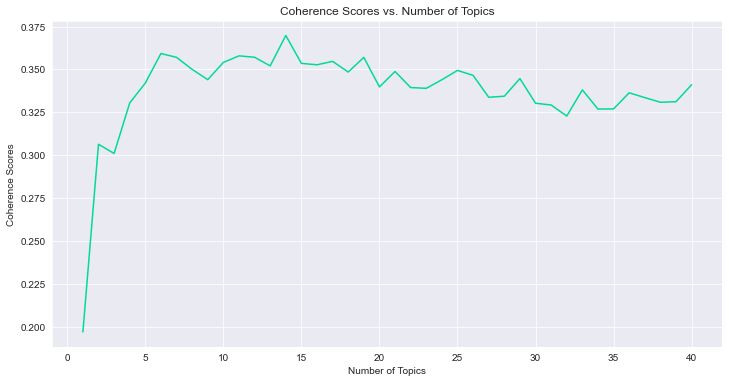

Optimal number of topics: 14


,num_topics,coherence_score
13,14,0.369780
5,6,0.359270
10,11,0.357882
11,12,0.357071
18,19,0.357015
6,7,0.357013
16,17,0.354677
9,10,0.354054
14,15,0.353507
15,16,0.352687


In [27]:
# Load from pickle 
id2word, doc_term_matrix = get_id2word_doc_matrix(lst_pros_final)
coherence_pros_df = find_optimal_topics(doc_term_matrix, id2word, lst_pros_final, min_topics=1, max_topics=40, display=True)
print(f'Optimal number of topics: {int(coherence_pros_df.iloc[0].num_topics)}')
coherence_pros_df

with open('coherence_pros_df.pickle', 'wb') as f:
    pickle.dump(coherence_pros_df, f)

**Interpretation:**
Optimal number of topics is 14. Scores rapidly go until score 6 and then level off through a higher number of topics. 

In [29]:
# Take the number of topics from above and create a model to print topics 
lda_model = LdaModel(corpus=doc_term_matrix, id2word=id2word, num_topics=14, random_state=123, passes=25)
lda_model.print_topics()

[(0,
  '0.022*"global" + 0.020*"building" + 0.020*"talent" + 0.018*"free lunch" + 0.018*"founder" + 0.014*"still" + 0.014*"successful" + 0.014*"company" + 0.013*"family" + 0.013*"low"'),
 (1,
  '0.047*"really" + 0.038*"working" + 0.028*"time" + 0.022*"well" + 0.019*"staff" + 0.019*"everyone" + 0.015*"learning" + 0.015*"employee" + 0.015*"get" + 0.015*"job"'),
 (2,
  '0.039*"firm" + 0.030*"work" + 0.027*"get" + 0.027*"strong" + 0.021*"better" + 0.020*"industry" + 0.017*"want" + 0.015*"career" + 0.015*"management" + 0.014*"professional"'),
 (3,
  '0.089*"opportunity" + 0.061*"learn" + 0.061*"lot" + 0.035*"many" + 0.022*"project" + 0.021*"culture" + 0.021*"smart people" + 0.021*"growth" + 0.016*"resource" + 0.016*"responsibility"'),
 (4,
  '0.125*"people" + 0.120*"great" + 0.109*"culture" + 0.044*"smart" + 0.033*"friendly" + 0.032*"amazing" + 0.025*"colleague" + 0.020*"company" + 0.019*"intelligent" + 0.017*"nice"'),
 (5,
  '0.241*"work" + 0.086*"great" + 0.082*"environment" + 0.059*"peop

In [37]:
# Visualize lda model 
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, doc_term_matrix, id2word)
vis 

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.223177 -0.087781       1        1  10.928157
4      0.198590 -0.072735       2        1   9.709922
10     0.235246  0.127295       3        1   9.254857
6      0.291551  0.075565       4        1   8.944492
12    -0.088071  0.031319       5        1   8.301758
2     -0.111919 -0.094101       6        1   7.824682
3     -0.116648  0.191731       7        1   7.202748
7      0.005310  0.095926       8        1   6.131001
8      0.013477 -0.216600       9        1   6.092521
1     -0.087551 -0.141095      10        1   6.056646
11    -0.151349 -0.141519      11        1   5.720508
13    -0.152853  0.168893      12        1   5.104732
0     -0.121645 -0.014759      13        1   4.598169
9     -0.137315  0.077861      14        1   4.129807, topic_info=          Term         Freq        Total Category  logprob  loglift
7         good  3669.000000  3669.000000  Default  30.0000  30.0000
15        work  2756.000000  2756.000000  Default  29.0000  29.0000
8        great  3998.000000  3998.000000  Default  28.0000  28.0000
0      benefit  1820.000000  1820.000000  Default  27.0000  27.0000
3       people  2535.000000  2535.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
810       paid    52.266894    96.463555  Topic14  -4.3291   2.5741
1384  changing    26.641269    32.481839  Topic14  -5.0030   2.9887
6      company    70.230748  1678.089565  Topic14  -4.0337   0.0133
455   business    43.829926   272.616186  Topic14  -4.5051   1.3592
550        top    31.880798   150.971569  Topic14  -4.8235   1.6319

[796 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
878       7  0.691876   ability
878      10  0.027311   ability
878      11  0.018207   ability
878      14  0.264005   ability
821       5  0.464962      able
...     ...       ...       ...
442      12  0.030369      year
442      13  0.066813      year
1697      4  0.966324  year end
850       6  0.856626     young
850       8  0.129081     young

[1156 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 5, 11, 7, 13, 3, 4, 8, 9, 2, 12, 14, 1, 10])

### 4. GSDMM Modeling

How it works link[https://towardsdatascience.com/short-text-topic-modelling-lda-vs-gsdmm-20f1db742e14]

While LDA performs very well on larger texts (>50 words or so), its performance tends to nose-dive when trying to model the topics of shorter texts, for the pretty obvious reason that a short text (such as a Tweet or the title of a forum question) is likely to refer to only a single topic.

#### Example:
“Imagine a bunch of students in a restaurant, seating randomly at K tables. They are all asked to write their favorite movies on a paper (but it must remain a short list). The objective is to cluster them in such a way that so students within the same group share the same movie interest. To do so, one after another, students must make a new table choice regarding the two following rules:
* Rule 1: Choose a table with more students. This rule improves completeness, all students sharing the same movie’s interest are assigned to the same table.
* Rule 2: Choose a table where students share similar movie’s interest. This rule aims to increase homogeneity, we want only members sharing the same movie’s interest at a table.

After repeating this process, we expect some tables to disappear and others to grow larger and eventually have clusters of students matching their movie’s interest. This is simply what the GSDMM algorithm does!”

https://github.com/rwalk/gsdmm

In [46]:

"""
This will generate a list of the total number of clusters, 
with the top {num_words} most-recurring words, and the number of times each of those top {num_words} words occurs in the topic.
"""
def top_words_gsdmm(cluster_word_distribution, cluster_indexes_sorted, num_words):
    for idx in cluster_indexes_sorted:
        if len(gsdmm.cluster_word_distribution[idx]) == 0:
            continue
        # each k, v in the dictionary is a word, frequency. x[1] is the frequency, sort by this number, and only include the top {num_words} words
        word_dict = sorted(cluster_word_distribution[idx].items(), key=lambda x: x[1], reverse=True)[:num_words]
        print(f'Cluster {idx}: {word_dict}')

"""
Generate 1 wordcloud based on topic number 
"""
def generate_wordcloud(cluster_word_distribution, topic_number, num_words, width=1800, height=700):
    topic_dict = sorted(gsdmm.cluster_word_distribution[topic_number].items(), key=lambda x: x[1], reverse=True)[:num_words]
    topic_dict = {item[0]:item[1] for item in topic_dict}
    
    wordcloud = WordCloud(width=width, height=height).generate_from_frequencies(topic_dict)
    return wordcloud

# generate_wordcloud(gsdmm.cluster_word_distribution, 10, 20)    

"""TODO takes in a list of topic numbers and produces an array of wordclouds """

"""
Plot multiple wordclouds based off of a cluster word dist
input: gsdmm cluster word distribution, and list of indexes of docs sorted by importances 
output: wordclouds plots of all clusters with words in them, sorted by importance 

"""
def plot_wordclouds(cluster_word_distribution, indexes_sorted):
    topic_numbers = [idx for idx in indexes_sorted if len(cluster_word_distribution[idx]) > 0]

    total_subplots = len(topic_numbers)
    cols = 4
    rows = total_subplots // cols
    if total_subplots % cols > 0:
        rows+=1
    print(f"Total plots: {total_subplots}, Total cols: {cols}, Total rows: {rows}")

    index=0
    fig,axes = plt.subplots(nrows=rows, ncols=cols, figsize=(25,15))
    index=0

    for row in range(axes.shape[0]):
        for col in range(axes.shape[1]):
            if index >= len(topic_numbers):
                fig.delaxes(axes[row,col])
                index+=1
            else:
                wordcloud = generate_wordcloud(gsdmm.cluster_word_distribution, topic_numbers[index], 20)
                ax = axes[row,col]
                ax.set_title(f'Topic Number: {topic_numbers[index]}')
                im = ax.imshow(wordcloud) #, interpolation='bilinear'
                ax.axis('off')
                index += 1

    plt.tight_layout()
    
""" Plot a single wordcloud """
def plot_wordcloud(cluster_word_distribution, topic_number, num_words):
    wordcloud = generate_wordcloud(cluster_word_distribution, topic_number, num_words)
    plt.figure(figsize=(20,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()


In [39]:
# Note that GSDMM only requires two input variables: the documents as a numpy array and the length of your dictionary/vocabulary.

# initialize GSDMM
gsdmm = MovieGroupProcess(K=15, alpha=0.1, beta=0.3, n_iters=15)
vocab_len = len(id2word)
# fit GSDMM model
y = gsdmm.fit(lst_pros_final, vocab_len) #total_word_count = len(tokens)

In stage 0: transferred 9764 clusters with 15 clusters populated
In stage 1: transferred 7857 clusters with 15 clusters populated
In stage 2: transferred 6392 clusters with 15 clusters populated
In stage 3: transferred 5048 clusters with 15 clusters populated
In stage 4: transferred 3993 clusters with 14 clusters populated
In stage 5: transferred 3444 clusters with 14 clusters populated
In stage 6: transferred 3118 clusters with 12 clusters populated
In stage 7: transferred 2867 clusters with 12 clusters populated
In stage 8: transferred 2726 clusters with 12 clusters populated
In stage 9: transferred 2633 clusters with 12 clusters populated
In stage 10: transferred 2604 clusters with 12 clusters populated
In stage 11: transferred 2427 clusters with 12 clusters populated
In stage 12: transferred 2341 clusters with 12 clusters populated
In stage 13: transferred 2335 clusters with 12 clusters populated
In stage 14: transferred 2266 clusters with 11 clusters populated


In [42]:
doc_count = np.array(gsdmm.cluster_doc_count)
# print('Number of documents per topic :', doc_count)

indexes_sorted = doc_count.argsort()[::-1]
print(f'Index of docs arranged by importance: {indexes_sorted}')

top_words_gsdmm(gsdmm.cluster_word_distribution, indexes_sorted, 20)

Index of docs arranged by importance: [ 0  4  5  8  2  1 14 13 10  9  7 12 11  6  3]
Cluster 0: [('good', 2415), ('great', 2278), ('work', 1446), ('people', 1303), ('benefit', 1193), ('culture', 781), ('pay', 600), ('company', 584), ('nice', 535), ('environment', 529), ('work life balance', 453), ('smart people', 309), ('place', 292), ('friendly', 281), ('team', 270), ('opportunity', 242), ('compensation', 217), ('management', 215), ('salary', 210), ('lot', 203)]
Cluster 4: [('great', 1018), ('work', 966), ('people', 826), ('company', 653), ('culture', 569), ('employee', 461), ('good', 457), ('opportunity', 370), ('team', 326), ('environment', 325), ('benefit', 307), ('management', 242), ('place', 241), ('learn', 222), ('firm', 206), ('lot', 197), ('really', 187), ('working', 183), ('best', 180), ('smart', 175)]
Cluster 5: [('good', 573), ('great', 449), ('benefit', 413), ('pay', 218), ('company', 204), ('people', 196), ('work', 192), ('nice', 168), ('office', 153), ('location', 119), 

In [44]:
# gsdmm.cluster_word_distribution[10].items()

Total plots: 11, Total cols: 4, Total rows: 3


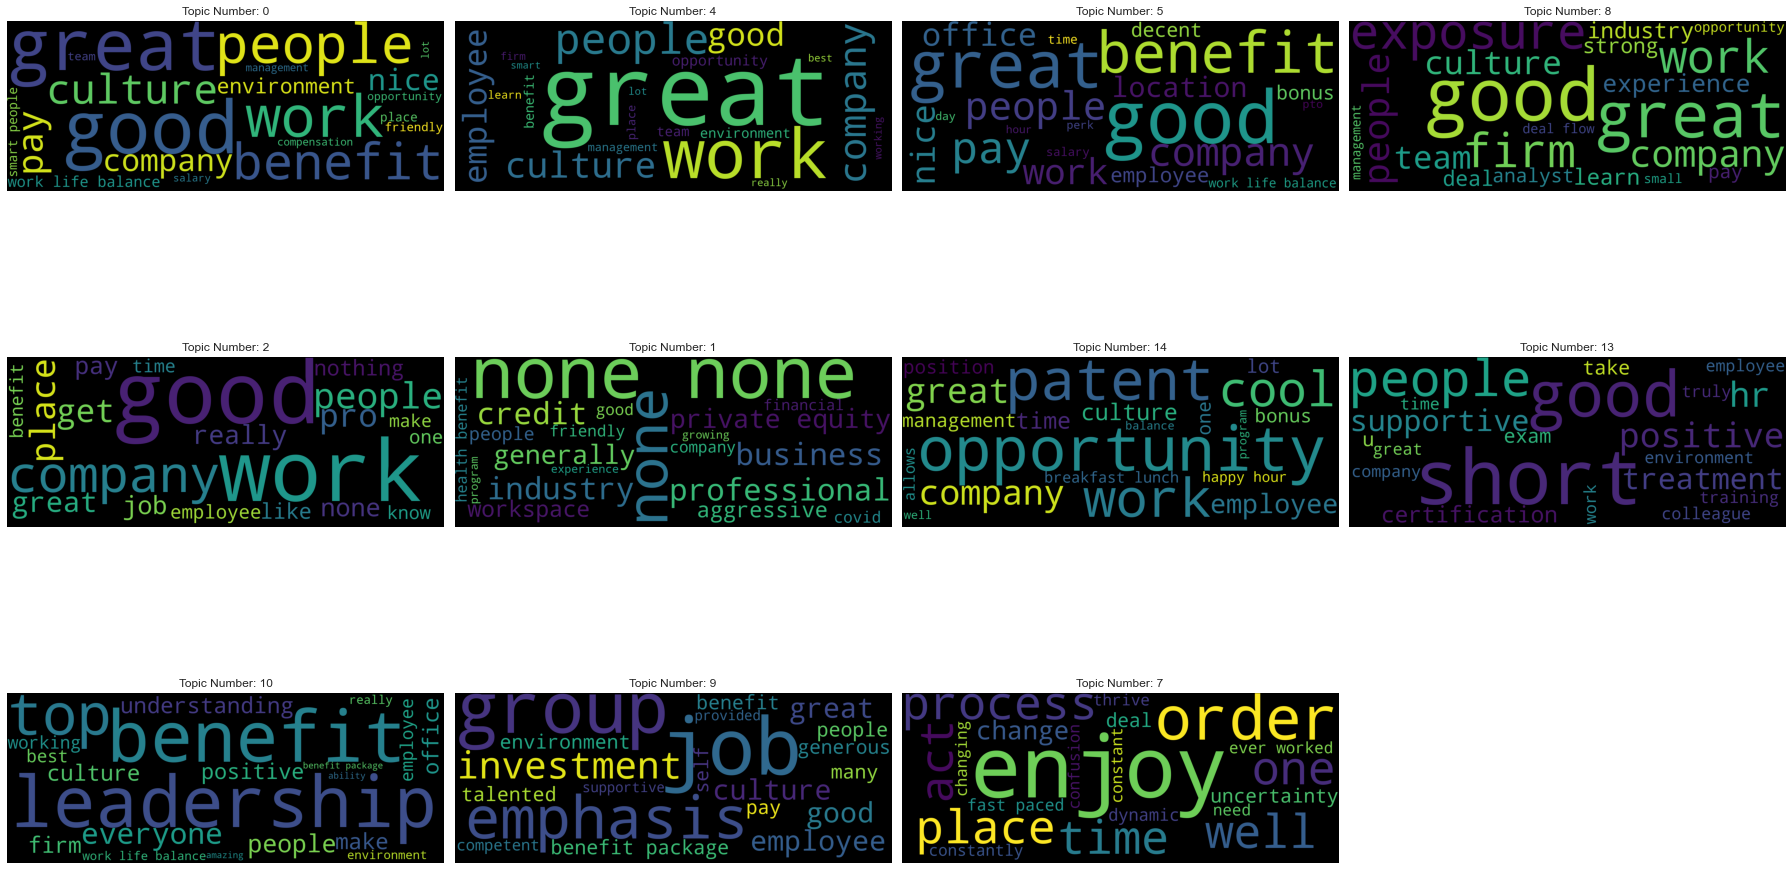

In [48]:
plot_wordclouds(gsdmm.cluster_word_distribution, indexes_sorted)

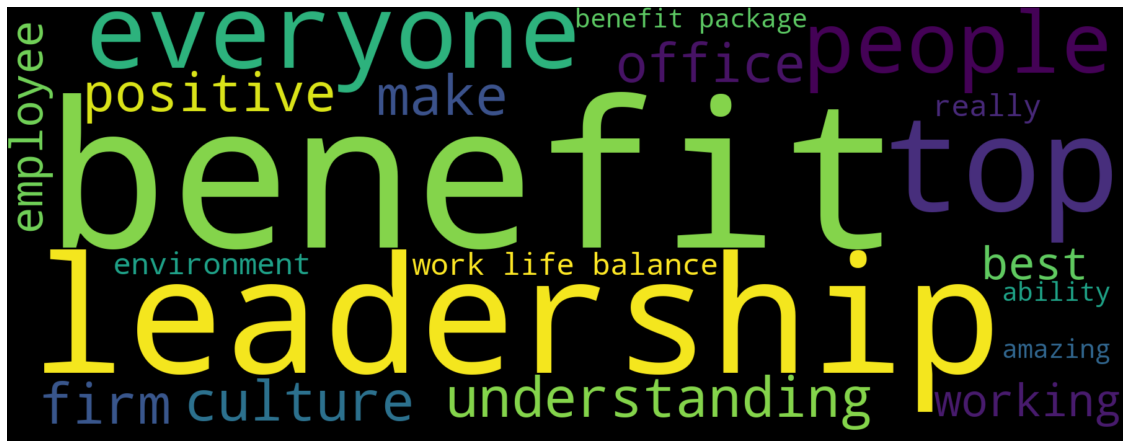

In [47]:
plot_wordcloud(gsdmm.cluster_word_distribution, 10, 20)

## Analyzing Cons Column
1. Most common words 
2. Bigrams and trigrams 
3. LDA 
4. GSDMM 

## Analyzing Headline Column
1. Most common words 
2. Bigrams and trigrams 
3. LDA 
4. GSDMM 

# Predictions

## TF-IDF

In [195]:
df.head()

,company,headline,date,overall_rating,author_position,pros,cons,position_department,position_level,pros_cleaned,cons_cleaned,headline_cleaned,combined_text
0,Allianz Global Investors,Great People,2022-04-21,5.0,Human Resources Business Partner,"People, benefits, management, team and culture.",I have no cons to share,hr,other,people benefit management team culture,son share,great people,people benefit management team culture son sha...
1,Allianz Global Investors,Great company,2022-04-11,5.0,Working Student,"Good culture, interesting company, great colle...",not encountered any so far,other,other,good culture interesting company great colleague,encountered far,great company,good culture interesting company great colleag...
2,Allianz Global Investors,Working Student,2022-04-07,5.0,Working Student,"Good company, nice colleagues, good perks","Nothing at the moment, everything is fine",other,other,good company nice colleague good peak,nothing moment everything fine,working student,good company nice colleague good peak nothing ...
3,Allianz Global Investors,Good employer,2022-04-05,5.0,IT Project Manager,Flexible working \r\nNice colleagues\r\nNew te...,the management is not always aligned to the cu...,technology,other,flexible working nice colleague new technology...,management always signed current technology,good employer,flexible working nice colleague new technology...
4,Allianz Global Investors,Mostly positive experience,2022-03-31,4.0,Analyst,Staff are generally approachable and collabora...,Internal decision making can be overly politic...,investment,other,staff generally unapproachable collaboration n...,internal decision making overlay political thu...,mostly positive experience,staff generally unapproachable collaboration n...


In [193]:
data = df['combined_text']
# data = lst_corpus_bigrams
target = df['overall_rating'].astype(int)

In [194]:
print(len(data))
print(len(lst_corpus_bigrams))
print(len(target))

11014
11014
11014


In [255]:
model = Pipeline([('vectorizer',TfidfVectorizer(ngram_range=(1,2), max_features=10000)),
                  ('classifier',MultinomialNB())])

In [256]:
cross_val_score(model, data, target, cv=5, error_score='raise') 

array([0.44130627, 0.42497793, 0.42144748, 0.43336275, 0.42541924])

## Word2Vec

In [17]:
# TODO create train test split with this 

corpus = df['combined_text']
lst_corpus = get_corpus_lst(corpus)

In [260]:
len(tokens)

320174

#### Definitions
* corpus: list of lists of n-grams
* padded sequence: every text (each list of n-grams) is now an id sequence with length X. For instance if length = 15, then if a text had 10 tokens in it, the sequence is composed of 10 ids + 5 0s, which is teh padding element. The id for word not in vocab is 1. 
* word embedding: vectors of words 

#### Process
1. Create or use a word embedding model to produce a vector space (usually several hundred dimensions) 
    * words that share common contexts in the corpsu are located close to one another in the space
2. Transform the corpus into padded sequences of word ids. Transform the corpus given to the word2vec into a list of sequences.
3. Create an embedding matrix so that the vector of the word with id N is located at the Nth row 
4. Build a neural network with an embedding layer that weighs every word in the sequences with the corresponding vector 

### Pre-trained GLOVE model 

In [24]:
with open('glove,pickle','rb') as f:
    glove = pickle.load(f)

In [261]:
# compare out of the box to custom trained one 
glove = {}

with open('glove.6B.50d.txt','rb') as f:
    for line in f: 
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in tokens:
            vector = np.array(parts[1:],dtype=np.float32)
            glove[word] = vector 
            

In [263]:
with open('glove,pickle','wb') as f:
    pickle.dump(glove, f)

### Custom Word2Vec 
use the training data corpus with gensim 

In [43]:
total = 0
max_len = 0 
count = 0 
for txt in lst_corpus_bigrams:
    total += len(txt)
    if max_len < len(txt):
        max_len = len(txt)
    if len(txt) > 25: 
        count+=1

    
avg_len = int(total/len(lst_corpus_bigrams))

print(avg_len)
print(max_len)
print(count)

25
602
3223


In [205]:
nlp = gensim.models.word2vec.Word2Vec(lst_corpus_bigrams,
                                      size=300,
                                      window=25,
                                      min_count=1,
                                      sg=1,
                                      iter=30)


In [151]:
print(len(nlp.wv.vocab))
word = "great"
nlp[word].shape

13793

In [35]:
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', oov_token="NaN", filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(lst_corpus_bigrams)
dic_vocabulary = tokenizer.word_index

In [75]:
# alternate to tokenizer 
total_vocab = set(word for text in lst_corpus_bigrams for word in text)
print(len(total_vocab))
print(len(dic_vocabulary))

13793
13794


In [85]:
glove[next(iter(glove))]

array([ 0.38973  , -0.2121   ,  0.51837  ,  0.80136  ,  1.0336   ,
       -0.27784  , -0.84525  , -0.25333  ,  0.12586  , -0.90342  ,
        0.24975  ,  0.22022  , -1.2053   , -0.53771  ,  1.0446   ,
        0.62778  ,  0.39704  , -0.15812  ,  0.38102  , -0.54674  ,
       -0.44009  ,  1.0976   ,  0.013069 , -0.89971  ,  0.41226  ,
       -2.2309   ,  0.28997  ,  0.32175  , -0.72738  , -0.092244 ,
        3.028    , -0.062599 ,  0.038329 ,  0.0072918, -0.35388  ,
       -0.92256  ,  0.097932 ,  0.10068  ,  1.2116   ,  0.88233  ,
       -0.46297  ,  1.3186   ,  0.32705  , -0.73446  ,  0.89301  ,
       -0.45324  , -1.2698   ,  0.86119  ,  0.1415   ,  1.2018   ],
      dtype=float32)

### Matrix of Embedding
create matrix of embeddidng to use as a weight matrix in the classifier 


In [206]:
# USE THE CUSTOM WORD2VEC MODEL 
embeddings = np.zeros((len(dic_vocabulary)+1, nlp.vector_size))
print(embeddings.shape)

# take each unique word from and get the vector from the custom word2vec model 
embeddings = np.zeros((len(dic_vocabulary)+1, nlp.vector_size))
for word,idx in dic_vocabulary.items():
    try:
        embeddings[idx] = nlp[word]
    # if the word is not in the model then that row is all 0s 
    except:
        pass

(12833, 300)


In [94]:
# USE THE CUSTOM WORD2VEC MODEL 
embeddings = np.zeros((len(dic_vocabulary)+1, nlp.vector_size))
print(embeddings.shape)

# take each unique word from and get the vector from the custom word2vec model 
embeddings = np.zeros((len(dic_vocabulary)+1, nlp.vector_size))
for word,idx in dic_vocabulary.items():
    try:
        embeddings[idx] = nlp[word]
    # if the word is not in the model then that row is all 0s 
    except:
        pass

(13795, 300)

In [116]:
# USE THE GLOVE MODEL 
# take each unique word from and get the vector from the glove model 
embeddings_glove = np.zeros((len(dic_vocabulary)+1, len(glove[next(iter(glove))]) ))
for word,idx in dic_vocabulary.items():
    try:
        embeddings_glove[idx] = glove[word]
    # if the word is not in the model then that row is all 0s 
    except:
        pass

In [101]:
for word,idx in dic_vocabulary.items():
    print(word,idx)

NaN 1
good 2
work 3
great 4
company 5
people 6
culture 7
management 8
employee 9
lot 10
benefit 11
pay 12
firm 13
time 14
team 15
get 16
environment 17
job 18
manager 19
many 20
great place 21
experience 22
’ 23
opportunity 24
place 25
working 26
balance 27
really 28
office 29
work life 30
much 31
one 32
like 33
nice 34
long hour 35
make 36
compensation 37
hour 38
need 39
business 40
best 41
come 42
hard 43
thing 44
year 45
bad 46
salary 47
place work 48
new 49
everyone 50
smart people 51
little 52
well 53
change 54
even 55
leadership 56
also 57
want 58
great benefit 59
career 60
department 61
work environment 62
growth 63
industry 64
way 65
know 66
could 67
always 68
technology 69
group 70
better 71
lack 72
day 73
excellent 74
training 75
learn 76
tear 77
process 78
amazing 79
long 80
organization 81
high 82
investment 83
take 84
sometimes 85
poor 86
role 87
're 88
would 89
friendly 90
project 91
overall 92
level 93
location 94
still 95
professional 96
market 97
position 98
challengin

impossible 1057
literally 1058
trade 1059
downside 1060
unclear 1061
prior 1062
tormented 1063
crazy 1064
free snack 1065
report 1066
recognized 1067
legacy 1068
went 1069
cult 1070
take time 1071
collection 1072
wh 1073
period 1074
add 1075
sit 1076
struggle 1077
code 1078
basic 1079
perform 1080
later 1081
happens 1082
extreme 1083
status 1084
seemed 1085
happening 1086
executive assistant 1087
fast-paced 1088
check 1089
seller 1090
putnam 1091
complaint 1092
new york 1093
vice president 1094
requires 1095
planning 1096
floor 1097
would recommend 1098
smiled 1099
claim 1100
lose 1101
pretty much 1102
paying 1103
price 1104
action 1105
complain 1106
rarely 1107
'd 1108
match 1109
bunch 1110
productive 1111
respected 1112
anywhere 1113
ego 1114
private equity 1115
free breakfast 1116
curve 1117
pu 1118
currently 1119
underpaid 1120
improved 1121
slightly 1122
personally 1123
act 1124
apply 1125
putting 1126
advancement opportunity 1127
capital 1128
call center 1129
training program 113

everything else 1736
disconnected 1737
decline 1738
immediate 1739
careful 1740
factor 1741
adding 1742
expanding 1743
proud 1744
date 1745
story 1746
account manager 1747
lean tear 1748
camp 1749
non-compete 1750
smart talented 1751
playing 1752
evolve 1753
therefore 1754
compensated 1755
networking 1756
amenity 1757
discus 1758
profitable 1759
top heavy 1760
root 1761
sitting 1762
many different 1763
day week 1764
request 1765
seat 1766
suit 1767
received 1768
team lead 1769
hard move 1770
revenue 1771
stressed 1772
phenomenon 1773
deeply 1774
paternity leave 1775
ok place 1776
continuous 1777
comparable 1778
th 1779
contact 1780
outcome 1781
hardly 1782
adviser 1783
employed 1784
rating 1785
strange 1786
fast-paced environment 1787
pantry 1788
rapid growth 1789
oh 1790
guess 1791
broker 1792
collaborate 1793
face time 1794
tried 1795
relevant 1796
company event 1797
efficiency 1798
unable 1799
stimulating 1800
outsourced 1801
committee 1802
rise 1803
influence 1804
address 1805
supe

facing 3024
applying 3025
allowance 3026
slaveholder 3027
sick time 3028
domain 3029
working together 3030
sacrifice 3031
positively 3032
equally 3033
inclusive culture 3034
mark 3035
inflation 3036
grow career 3037
outdated technology 3038
rapidly growing 3039
counterpart 3040
needle 3041
non extent 3042
another job 3043
parental leave 3044
retirement benefit 3045
worry 3046
never felt 3047
update 3048
'll learn 3049
guide 3050
anything done 3051
stupid 3052
direct report 3053
grade 3054
distance 3055
dull 3056
well-being 3057
open-minded 3058
many meeting 3059
help grow 3060
egotistic 3061
wear many 3062
corp 3063
king 3064
access senior 3065
total compensation 3066
vast majority 3067
countless 3068
want see 3069
different area 3070
internet 3071
disparity 3072
departmental 3073
excuse 3074
paid vacation 3075
need improve 3076
regulation 3077
one worst 3078
fool 3079
phone call 3080
iso 3081
letter 3082
failing 3083
boy 3084
run away 3085
along way 3086
advance career 3087
feed 3088


direct manager 4056
global presence 4057
regular basis 4058
emerging 4059
accept offer 4060
easy going 4061
twitching 4062
breaking 4063
headed 4064
abundant 4065
franchise 4066
well organized 4067
month end 4068
he/she 4069
closer 4070
keep busy 4071
buying 4072
greed 4073
blue 4074
cultivating 4075
map 4076
'll ever 4077
questioned 4078
nativity 4079
grand 4080
common sense 4081
judged 4082
recorded 4083
chef 4084
resource available 4085
enhance 4086
help develop 4087
adopt 4088
blood 4089
selected 4090
layer management 4091
rumor 4092
result tormented 4093
meaningless 4094
clear path 4095
trivial 4096
glass ceiling 4097
terrible work/life 4098
forcing 4099
extended 4100
announced 4101
open communication 4102
boot 4103
lady 4104
dumb 4105
psychological 4106
decides 4107
dishonest 4108
tremendous amount 4109
unwilling 4110
office beautiful 4111
neighborhood 4112
upright 4113
asks 4114
bit political 4115
faint heart 4116
relatively low 4117
open source 4118
office located 4119
verbally

wider 4830
ill 4831
guilty 4832
hitting 4833
break room 4834
tune 4835
first hand 4836
making stride 4837
'll fine 4838
loss litigation 4839
corporate function 4840
secure 4841
supposedly 4842
deficiency 4843
enhanced 4844
vacation sick 4845
prof 4846
scattered 4847
five year 4848
advise 4849
part-time 4850
wasting 4851
funding 4852
automobile financing 4853
movie 4854
marginal 4855
thou 4856
treasury 4857
huge emphasis 4858
uneasy 4859
turf 4860
industry-leading 4861
democratic 4862
downtime 4863
crash 4864
novel 4865
instruction 4866
discriminatory practice 4867
organisational 4868
taste 4869
mail 4870
union 4871
suffered 4872
fresh college 4873
harassing 4874
justice 4875
deteriorating 4876
impacted 4877
extra mile 4878
enhancement 4879
generally speaking 4880
texas 4881
kick 4882
timely 4883
obtain 4884
due rapid 4885
never boring 4886
stream 4887
component 4888
completing 4889
crop 4890
altogether 4891
product offering 4892
insecurity 4893
high visibility 4894
geographical 4895
gr

charging 5976
eliminated 5977
corrupted 5978
wicked 5979
enriching 5980
prioritizes 5981
considerably 5982
requested 5983
mimi 5984
coral 5985
gable 5986
noble 5987
screw 5988
disarray 5989
peter 5990
punished 5991
mall 5992
intimidate 5993
proceed 5994
mot 5995
bidding 5996
courteous 5997
illogical 5998
claiming 5999
array 6000
sing 6001
rockefeller 6002
slightest 6003
echelon 6004
calendar 6005
comprise 6006
back-stabbing 6007
securing 6008
ignores 6009
small size 6010
realizing 6011
proposition 6012
articulated 6013
propose 6014
salesperson 6015
non-distant 6016
neutral 6017
mmm 6018
attentive 6019
paramount 6020
cumbersome 6021
unequal 6022
rush 6023
liking 6024
mio 6025
explicit 6026
transferring 6027
mercenary 6028
tape 6029
probed 6030
adhering 6031
fostered 6032
succession 6033
deferential 6034
critique 6035
attribute 6036
lesson 6037
deeper 6038
agility 6039
gut 6040
super-smart 6041
bush 6042
tm 6043
thread 6044
mysterious 6045
cup 6046
closed door 6047
bear 6048
husband 6049

etiquette 7055
lipping 7056
poster 7057
ni 7058
etes 7059
stink 7060
slowed 7061
trainee 7062
anderson 7063
traction 7064
misalignment 7065
mingle 7066
perpetrated 7067
grasping 7068
youthful 7069
algorithmic 7070
complementary 7071
adapt change 7072
meg 7073
rooted 7074
dugout 7075
analysis/associates 7076
leash 7077
universe 7078
brand resume 7079
trade-off 7080
firmly 7081
bombarded 7082
his/week 7083
afforded 7084
well-recognized 7085
aunt 7086
franklin 7087
simpleton 7088
lagged 7089
telecommute 7090
county 7091
keen 7092
skyline 7093
planted 7094
predominantly 7095
tap 7096
forum 7097
underutilized 7098
stanley 7099
team-building 7100
clothing 7101
striped 7102
soak 7103
sage 7104
machinery 7105
grid 7106
none- 7107
boast 7108
duplicate 7109
conscientious 7110
aggregated 7111
ed 7112
poison 7113
shock 7114
chauvinistic 7115
contracted 7116
unicorn 7117
seminary 7118
shabby 7119
patella 7120
weinberg 7121
executing 7122
crack 7123
cavern 7124
bandwidth 7125
mat 7126
hopeful 7127
d

introducing 8305
patriarch 8306
multitask 8307
averaged 8308
ensued 8309
envious 8310
ghost 8311
disclosing 8312
interim 8313
entrusting 8314
lieu 8315
employing 8316
humiliate 8317
comfortably 8318
leads/managers 8319
results-tormented 8320
salt 8321
allergic 8322
autocratic 8323
caustic 8324
foul 8325
incur 8326
anchor 8327
mole 8328
purge 8329
non-managerial 8330
marched 8331
solidarity 8332
assurance 8333
resolving 8334
lowballing 8335
undeserved 8336
demonetization 8337
terrapower 8338
customized 8339
overlapping 8340
grey 8341
composed 8342
drained 8343
projects/areas 8344
preserving 8345
canceled 8346
solidified 8347
poverty 8348
signify 8349
exploded 8350
roam 8351
inter-departmental 8352
monetize 8353
involve 8354
mixture 8355
multi-national 8356
aptitude 8357
collected 8358
controversy 8359
controversial 8360
compromised 8361
groupthink 8362
s/w 8363
diminish 8364
missionary 8365
electric 8366
settled 8367
self-taught 8368
realise 8369
rental 8370
moody 8371
frank 8372
oblige

incurring 9354
h/c 9355
products/experience 9356
y/e 9357
careless/useless 9358
politics/blame 9359
overlevered 9360
closed-minded 9361
devise 9362
plethera 9363
resources/training 9364
opportunities/clubs/philanthropic 9365
explosion 9366
bootcamps 9367
equino 9368
pre-tax 9369
hour+ 9370
debut 9371
drops/infrastructure-wise 9372
poured 9373
bed 9374
icon 9375
brilliantly 9376
street-smart 9377
book-smart 9378
whiteboard 9379
point… 9380
joint 9381
growth/success 9382
seedless 9383
post-employment 9384
programming/investment/etc 9385
accumulation 9386
ridden 9387
titles/hierarchy 9388
street/above 9389
accumulation/business 9390
raving 9391
devoid 9392
hamstring 9393
pre-financial 9394
alluded 9395
over-crowded 9396
valet 9397
one-stop-shop 9398
granular 9399
urban 9400
performance-wise 9401
bustling 9402
dog-eat-dog 9403
horrible/non 9404
cost-center 9405
rage 9406
banks/financial 9407
shutting 9408
conferences/training 9409
westchester 9410
transferability 9411
lock-step 9412
pad-ma

paradoxical 10184
wielded 10185
accurately 10186
disuse 10187
perilously 10188
bottoms-up 10189
rot 10190
tidbit 10191
aphorism 10192
hairball 10193
debugging 10194
speckle 10195
good-quality 10196
intending 10197
under-performance 10198
rewarding/tough 10199
laypeople 10200
browbeaten 10201
brandname 10202
markets/investing 10203
senior/accomplished 10204
headhunter 10205
devour 10206
diagnosed 10207
servitude 10208
reducing 10209
career/job 10210
new/more 10211
thinking/approaching 10212
maturity/growth 10213
bonds/friendships 10214
authority/seniority 10215
stunted 10216
surveillance/paranoid 10217
wring 10218
case-study 10219
curtis-egotism 10220
diversionary 10221
non-issue 10222
short-comings 10223
afar 10224
formulate 10225
scarlet 10226
ripe 10227
inflict 10228
interrogative 10229
invalid 10230
creator 10231
information/thoughts 10232
turnover/lack 10233
continuity 10234
bruce 10235
people/knowledge 10236
after-work 10237
mon-the 10238
people/roles 10239
hue 10240
ha 10241
inef

transparent- 11227
recognition- 11228
bodes 11229
plastic 11230
entering/leaving 11231
training/continuing 11232
battery 11233
badmouth 11234
tools/software 11235
mistaking 11236
conspired 11237
sa/has 11238
stabbed 11239
staff/workers 11240
b'day 11241
fearfulness 11242
prescribed 11243
peril 11244
carl 11245
lewis 11246
performance-tormented 11247
comprising 11248
finance-tormented 11249
high-net-worth 11250
high-performer 11251
bustle 11252
legendary 11253
antrum 11254
illegally 11255
food/parties 11256
impart 11257
perseverance 11258
hesitated 11259
panic 11260
prospecting 11261
inadequately 11262
surpassed 11263
promotion/track 11264
ascertaining 11265
title/salary 11266
helter 11267
skelter 11268
sidetracked 11269
days/weeks 11270
non-uniformity 11271
fratenizes 11272
nepotisim 11273
greek 11274
unsteady 11275
interdepartment 11276
undo 11277
。 11278
dis-respect 11279
farther 11280
ditch 11281
aaaaaa 11282
booted 11283
re-evacuated 11284
plague 11285
bracket 11286
bookkeeping 112

excusable 12304
chewing 12305
dandy 12306
brushed 12307
gridlock 12308
backstory 12309
fairytale 12310
murdered 12311
disguise 12312
obliterated 12313
caricature 12314
undocumented 12315
sabotaging 12316
excused 12317
ticking 12318
timebomb 12319
better/more 12320
department/function 12321
blackrock/fidelity/vanguard 12322
peculiarly 12323
bicycle 12324
browsing 12325
localised 12326
self-absorbed 12327
tallied 12328
+benefits 12329
reconciled 12330
broad-based 12331
party/public 12332
nearest 12333
easygoing 12334
cake 12335
elderly 12336
youth 12337
stalked 12338
reckons 12339
inward-looking 12340
boys-club 12341
promotion/advancement 12342
possession/selfish 12343
repressed 12344
perry 12345
misandrist 12346
prolong 12347
entreprenerial 12348
coax 12349
extermination 12350
correspond 12351
mid-manager 12352
amiable 12353
analyst/paralegal 12354
dragged 12355
practitioner 12356
post- 12357
with/for 12358
tennis 12359
managers/even 12360
backwardness 12361
crupper 12362
bunk 12363
gri

completbal 13347
closed-mindedness 13348
lavish 13349
quasi 13350
seniority-based 13351
accumulate 13352
fatal 13353
enterpreniorial 13354
ventilator 13355
workculture 13356
workstyle 13357
rival 13358
solder 13359
wished 13360
trauma 13361
non-japanese 13362
technical-tormented 13363
teach~~~ 13364
management-level 13365
practice/expect 13366
submissive 13367
team/project 13368
solar 13369
usage 13370
globalism 13371
bitch 13372
serendipitous 13373
bankers/consultant 13374
career- 13375
on-ground 13376
・salary 13377
・no 13378
formality 13379
fast，new 13380
worklife 13381
balance，overcome 13382
front-loading 13383
off-sites 13384
additute 13385
shimbashi 13386
back-calling 13387
izakaya 13388
full-day 13389
professionalize 13390
・almost 13391
・charismatic 13392
・not 13393
・a 13394
・very 13395
・might 13396
buggy 13397
shiodome 13398
commence 13399
takeaway 13400
proposal 13401
robocup 13402
techcrunch 13403
upstream 13404
・volunteers 13405
・poor 13406
well-publicized 13407
characterized

In [118]:
embeddings_glove[2] == glove['good']

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [ ]:
embeddings[2] == nlp['good']

In [119]:
dic_vocabulary['good']

2

### Mean Word Embeddings

Note: One problem you may have noticed with the mean word embedding strategy is that by combining all the words, you lose some information that is contained in the sequence of the words. In natural language, the position and phrasing of words in a sentence can often contain information that we pick up on.

mean word embeddings: for classification - we need more than just a single word vector because classification 
is based on different sized blobs of text such as sentences or parahraphs. 
Mean word embeddings gets all of these sentences into a format that can be used for 
classification and uses word embedding model.

In [152]:
"""
Pass the data straight in and generate mean word embeddings on the fly. 
Don't need to write the same code twice to generate mean word embeddings for train and test sets
Also allows work with large datasets 
use a fit transform so it can be used in a scikitlearn pipeline 
Get the vector representation for a blob of text and average it out. 
"""

class MeanWordEmbedding(object):
    
    def __init__(self, w2v):
        # Takes in a dictionary of words and vectors as input
        self.w2v = w2v
        try:
            length = len(w2v)
        except:
            length = len(w2v.wv.vocab)
        if length == 0:
            self.dimensions = 0
        else:
            try:
                self.dimensions = len(w2v[next(iter(w2v))])
            except:
                self.dimensions = w2v.vector_size

    
    # Note: Even though it doesn't do anything, it's required that this object implement a fit method or else
    # it can't be used in a scikit-learn pipeline  
    def fit(self, X, y):
        return self
            
    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

In [310]:
glove_rf = Pipeline([('vectorizer',MeanWordEmbedding(glove)),('classifier',RandomForestClassifier())])
custom_rf = Pipeline([('vectorizer',MeanWordEmbedding(nlp)),('classifier',RandomForestClassifier())])

glove_svc = Pipeline([('vectorizer',MeanWordEmbedding(glove)),('classifier',SVC())])
custom_svc = Pipeline([('vectorizer',MeanWordEmbedding(nlp)),('classifier',SVC())])

models = [('Random Forest Glove', glove_rf), ('Random Forest Custom', custom_rf),
          ('SVM Glove', glove_svc), ('SVM Custom', custom_svc)]

In [311]:
scores = [(name, cross_val_score(model, data, target, cv=5, error_score='raise').mean()) for name, model in models]

In [312]:
scores

[('Random Forest Glove', 0.34174565028367315),
 ('Random Forest Custom', 0.3306703805355013),
 ('SVM Glove', 0.32358813821298094),
 ('SVM Custom', 0.32358813821298094)]

### Deep Learning + Embedding Layers

In [202]:
tokenizer = text.Tokenizer() #lower=True, split=' ', oov_token="NaN", filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
tokenizer.fit_on_texts(lst_corpus_bigrams)
dic_vocabulary = tokenizer.word_index
print(f'There are {len(dic_vocabulary)} words in the vocabulary.')

# create sequence 
lst_text2seq = tokenizer.texts_to_sequences(lst_corpus_bigrams)

# create padded sequencing 
padded_seq = sequence.pad_sequences(lst_text2seq, maxlen=100, padding='post', truncating='post')


There are 12832 words in the vocabulary.


In [56]:
# sequence printed 
print(dic_vocabulary['benefit'])
print(lst_corpus_bigrams[0])
print(lst_text2seq[0])

11
['people', 'benefit', 'management', 'team', 'culture', 'son', 'share', 'great', 'people']
[6, 11, 8, 15, 7, 114, 687, 4, 6]


In [62]:
print(type(padded_seq))
print(padded_seq.shape)
print(padded_seq[0])

<class 'numpy.ndarray'>
(11330, 50)
[  6  11   8  15   7 114 687   4   6   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


In [67]:
# visualize transformation 
print('original: ', df.combined_text.iloc[0])
print('\ncorpus: ', lst_corpus_bigrams[0])
print('\nsequence: ', lst_text2seq[0])
print('\npadded sequence: \n', padded_seq[0])

original:  people benefit management team culture son share great people

corpus:  ['people', 'benefit', 'management', 'team', 'culture', 'son', 'share', 'great', 'people']

sequence:  [6, 11, 8, 15, 7, 114, 687, 4, 6]

padded sequence: 
 [  6  11   8  15   7 114 687   4   6   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


In [207]:
embeddings.shape[1]

300

In [276]:
len(glove)

9956

In [210]:
from tensorflow.keras import models

In [301]:
# CUSTOM W2VEC
# define layers

# input
x_in = layers.Input(shape=(len(padded_seq[0]),))

# embedding - creating embedding for each blob 
# take in lenght of vocabulary, output length of 1 word vector using the embedding matrix 
x = layers.Embedding(input_dim=embeddings.shape[0], 
                     output_dim=embeddings.shape[1],
                     weights=[embeddings],
                     input_length=len(padded_seq[0]), 
                     trainable=False)(x_in)

# bidirectional lstm
x = layers.Bidirectional(layers.LSTM(units=len(padded_seq[0]), dropout=0.2, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(units=len(padded_seq[0]), dropout=0.2))(x)

# final dense layers
x=layers.Dense(64, activation='relu')(x)
y_out = layers.Dense(6, activation='softmax')(x)

# compile 
model=models.Model(x_in, y_out,name='Custom W2Vec Embeddings Model 1')
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "Custom W2Vec Embeddings Model 1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 100)]             0         
                                                                 
 embedding_25 (Embedding)    (None, 100, 300)          3849900   
                                                                 
 bidirectional_28 (Bidirecti  (None, 100, 200)         320800    
 onal)                                                           
                                                                 
 bidirectional_29 (Bidirecti  (None, 200)              240800    
 onal)                                                           
                                                                 
 dense_44 (Dense)            (None, 64)                12864     
                                                                 
 dense_45 (Dense)            (None,

In [295]:
model.fit(padded_seq, target, epochs=10, batch_size=256, validation_split=0.3)

Epoch 1/10
16/16 [==============================] - 50s 3s/step - loss: 0.1091 - accuracy: 0.9586 - val_loss: 2.8958 - val_accuracy: 0.4517
Epoch 2/10
16/16 [==============================] - 50s 3s/step - loss: 0.0854 - accuracy: 0.9712 - val_loss: 2.9854 - val_accuracy: 0.4560
Epoch 3/10
16/16 [==============================] - 51s 3s/step - loss: 0.0734 - accuracy: 0.9742 - val_loss: 3.1207 - val_accuracy: 0.4523
Epoch 4/10
16/16 [==============================] - 51s 3s/step - loss: 0.0880 - accuracy: 0.9694 - val_loss: 3.1380 - val_accuracy: 0.4514
Epoch 5/10
16/16 [==============================] - 53s 3s/step - loss: 0.0757 - accuracy: 0.9739 - val_loss: 3.2276 - val_accuracy: 0.4526
Epoch 6/10
16/16 [==============================] - 53s 3s/step - loss: 0.0691 - accuracy: 0.9739 - val_loss: 3.2260 - val_accuracy: 0.4530
Epoch 7/10
16/16 [==============================] - 52s 3s/step - loss: 0.0705 - accuracy: 0.9756 - val_loss: 3.2830 - val_accuracy: 0.4499
Epoch 8/10
16/16 [==

In [302]:
# GLOVE 
# define layers

# input
x_in = layers.Input(shape=(len(padded_seq[0]),))

# embedding - creating embedding for each blob 
# take in lenght of vocabulary, output length of 1 word vector using the embedding matrix 
x = layers.Embedding(input_dim=embeddings_glove.shape[0], 
                     output_dim=embeddings_glove.shape[1],
                     weights=[embeddings_glove],
                     input_length=len(padded_seq[0]), 
                     trainable=False)(x_in)

# bidirectional lstm
x = layers.Bidirectional(layers.LSTM(units=len(padded_seq[0]), dropout=0.2, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(units=len(padded_seq[0]), dropout=0.2))(x)

# final dense layers
x=layers.Dense(64, activation='relu')(x)
y_out = layers.Dense(6, activation='softmax')(x)

# compile 
model=models.Model(x_in, y_out, name='Glove Embeddings Model 1')
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "Glove Embeddings Model 1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 100)]             0         
                                                                 
 embedding_26 (Embedding)    (None, 100, 50)           689750    
                                                                 
 bidirectional_30 (Bidirecti  (None, 100, 200)         120800    
 onal)                                                           
                                                                 
 bidirectional_31 (Bidirecti  (None, 200)              240800    
 onal)                                                           
                                                                 
 dense_46 (Dense)            (None, 64)                12864     
                                                                 
 dense_47 (Dense)            (None, 6)    

In [290]:
model.fit(padded_seq, target, epochs=10, batch_size=256, validation_split=0.3)

Epoch 1/10
31/31 [==============================] - 57s 2s/step - loss: 1.5462 - accuracy: 0.3122 - val_loss: 1.4423 - val_accuracy: 0.3492
Epoch 2/10
31/31 [==============================] - 47s 2s/step - loss: 1.4543 - accuracy: 0.3499 - val_loss: 1.4309 - val_accuracy: 0.3362
Epoch 3/10
31/31 [==============================] - 47s 2s/step - loss: 1.4231 - accuracy: 0.3622 - val_loss: 1.4326 - val_accuracy: 0.3395
Epoch 4/10
31/31 [==============================] - 47s 2s/step - loss: 1.4121 - accuracy: 0.3696 - val_loss: 1.3896 - val_accuracy: 0.3540
Epoch 5/10
31/31 [==============================] - 48s 2s/step - loss: 1.3966 - accuracy: 0.3832 - val_loss: 1.3906 - val_accuracy: 0.3522
Epoch 6/10
31/31 [==============================] - 49s 2s/step - loss: 1.3809 - accuracy: 0.3930 - val_loss: 1.3797 - val_accuracy: 0.3876
Epoch 7/10
31/31 [==============================] - 48s 2s/step - loss: 1.3685 - accuracy: 0.3898 - val_loss: 1.3698 - val_accuracy: 0.3797
Epoch 8/10
31/31 [==

In [307]:
# MODEL #2 

model = Sequential(name='Model_2_Custom')

model.add(Input(shape=(len(padded_seq[0]),)))
model.add(Embedding(embeddings.shape[0], embeddings.shape[1]))
model.add(LSTM(len(padded_seq[0]), return_sequences=True))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))
model.summary()

Model: "Model_2_Custom"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_29 (Embedding)    (None, 100, 300)          3849900   
                                                                 
 lstm_42 (LSTM)              (None, 100, 100)          160400    
                                                                 
 global_max_pooling1d_10 (Gl  (None, 100)              0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_20 (Dropout)        (None, 100)               0         
                                                                 
 dense_52 (Dense)            (None, 50)                5050      
                                                                 
 dropout_21 (Dropout)        (None, 50)                0         
                                                    

In [308]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [309]:
y = pd.get_dummies(target).values
model.fit(padded_seq, y, epochs=10, batch_size=256, validation_split=0.3)

Epoch 1/10
31/31 [==============================] - 22s 624ms/step - loss: 1.5560 - accuracy: 0.2856 - val_loss: 1.4934 - val_accuracy: 0.3359
Epoch 2/10
31/31 [==============================] - 17s 537ms/step - loss: 1.4908 - accuracy: 0.3209 - val_loss: 1.4272 - val_accuracy: 0.3470
Epoch 3/10
31/31 [==============================] - 17s 538ms/step - loss: 1.3366 - accuracy: 0.3981 - val_loss: 1.2521 - val_accuracy: 0.4360
Epoch 4/10
31/31 [==============================] - 17s 535ms/step - loss: 1.1994 - accuracy: 0.4575 - val_loss: 1.1965 - val_accuracy: 0.4608
Epoch 5/10
31/31 [==============================] - 15s 501ms/step - loss: 1.0840 - accuracy: 0.5136 - val_loss: 1.2038 - val_accuracy: 0.4657
Epoch 6/10
31/31 [==============================] - 15s 496ms/step - loss: 0.9859 - accuracy: 0.5722 - val_loss: 1.2463 - val_accuracy: 0.4593
Epoch 7/10
31/31 [==============================] - 16s 502ms/step - loss: 0.8879 - accuracy: 0.6185 - val_loss: 1.3378 - val_accuracy: 0.4502

## Bert